Covid-19 Vaccine Tweets and Sentiment Analysis - NLP Project by S.Huang 

Project Started on 1/31/2022

Data Accessed Date: according to Kaggle, this dataset should be populated between 2020/12 and 2021/11

**Purpose & Goal**

The goal of this project is to explore texrt mining applications. Specifically to analyze text/tweets from a Kaggle dataset on a topic around Covid-19 vaccine and its assciated public sentiments towards it. 

**Metholodogy**

Started by extracting and pulling data via Kaggle API call. Followed by using numerous of existing python built-in packages (pandas, nltk) to preprocess 'tweet' so as to obtain a 'clean' version of tweet for visulaization via wordcloud, matplotlib. Then, we'll apply textblob and vader analysis in exploring and analyzing the predominant sentiment around this topic. 
Finally, we'll explore some basics of text classification such as feature generation using TF-IDF and applying it to KMeans clustering algorithm to further explore and group data.


**Result**

Majority of these tweets show neutral emotions towards covid vaccines. It seemed more nagative tweets were picked up by vader analysis.

**Areas to Work on**

Add additional wordcloud to display positive/negative tweets and add unigrams/bigrams for visuals(ref: https://github.com/vaisakhnambiar/Web-scraping/blob/master/Amazon%20Reviews%20Analysis.ipynb)

There's no train/test split in the data 

We could also apply other algorithms (i.e Multinomial Naive Bayes classifier) to the data # https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk

# Step 1: Import Packages

In [129]:
#######################################################################################
# Install new package 
#%pip install -tweepy #run in terminal
#%pip install vaderSentiment #run in terminal
#%pip install --upgrade vaderSentiment
#%pip install emoji --upgrade

#######################################################################################
# Pandas 
import os
import pandas as pd
import numpy as np

#######################################################################################
# Tweepy, NLP libraries & Image
import tweepy # For parsing tweets
import nltk
from nltk import RegexpParser
from nltk import word_tokenize, pos_tag, pos_tag_sents # use pos_tag_sents() for efficient tagging of more than one sentence
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TweetTokenizer # tokenizers written specifically for twitter text
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter # To count the tags A counter is a dictionary subclass works on principle of key-value operation 
# It is an unordered collection where elements are stored as a dictionary key while the count is their value.
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob, Word, Blobber
from textblob.sentiments import NaiveBayesAnalyzer #Importing the NaiveBayesAnalyzer classifier from NLTK
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from PIL import Image
import re # regular expression
import emoji 
from emoji import emojize
import string
from string import punctuation


#######################################################################################
# Python Sklearn ML libraries  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans


#######################################################################################
# Pyspark SQL and functions
from pyspark import SparkFiles
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col #user defined functions  (UDF)

#######################################################################################
# Pyspark ML Libraries
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator


#######################################################################################
# Credentials and RDBMS Connections
import cx_Oracle
import os


#######################################################################################
# Visualization
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


#######################################################################################
# Disable Warnings
import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('Do not show this message')


In [2]:
# Check installed packages 
#!conda list -n py3.6

# Locate Home Directory
%pwd
!pwd

'/home/AC27802'

/home/AC27802


In [3]:
#%cat /home/AC27802/AC27802.keytab

In [4]:
%ls -l /home/AC27802/.kaggle/
%cat /home/AC27802/.kaggle/kaggle.json
%cat /home/AC27802/.kaggle.json

total 4
-rw-r--r-- 1 AC27802 AC27802 64 Jan 25 17:59 kaggle.json
{"username":"jennysmh","key":"a01da1a07a7c40872229bac4149ecdb6"}{"username":"jennysmh","key":"a01da1a07a7c40872229bac4149ecdb6"}

# Step 2: Connect Kaggle API

In [5]:
# Retrieve API Key 
!cat /home/AC27802/.kaggle.json
!chmod 600 /home/AC27802/.kaggle.json

{"username":"jennysmh","key":"a01da1a07a7c40872229bac4149ecdb6"}

In [6]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

In [7]:
# initialize API and authenticate/ connect with API

api = KaggleApi()
api.authenticate()

# Step 3: Pull Kaggle Dataset 

In [8]:
# Read Standalone Dataset (this is not competition dataset)

## download dataset onto home directory
api.dataset_download_file('gpreda/all-covid19-vaccines-tweets', 
                          file_name='vaccination_all_tweets.csv')

False

In [9]:
import zipfile

# unzip csv file in home directory 
with zipfile.ZipFile('vaccination_all_tweets.csv.zip', 'r') as zipref:
    zipref.extractall()

In [10]:
# Read CSV data in Home Directory 

df = pd.read_csv("/home/AC27802/vaccination_all_tweets.csv")
df.head(2)


print("There are {} observations and {} features in this dataset. \n".format(df.shape[0],df.shape[1]))
print("There are {} sources in this dataset such as {}... \n".format(len(df.source.unique()),",".join(df.source.unique()[0:5])))
print("There are {} user_name in this dataset such as {}... \n".format(len(df.user_name.unique()),
                                                                                      ",".join(df.user_name.unique()[0:5])))

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False


There are 228207 observations and 16 features in this dataset. 

There are 380 sources in this dataset such as Twitter for Android,Twitter Web App,Twitter for iPhone,TweetDeck,Buffer... 

There are 85550 user_name in this dataset such as Rachel Roh,Albert Fong,eli🇱🇹🇪🇺👌,Charles Adler,Citizen News Channel... 



In [11]:
df.dtypes

#Checking for NaN values
df.isna().sum()

#Removing NaN Values
#df.dropna(inplace = True)

id                   int64
user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
retweets             int64
favorites            int64
is_retweet            bool
dtype: object

id                      0
user_name               2
user_location       66911
user_description    17018
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            49703
source                119
retweets                0
favorites               0
is_retweet              0
dtype: int64

# Step 4: Data Transformation

In [12]:
df['text'] = df['text'].astype(str)
df['user_followers'] = df['user_followers'].astype(float)
df.dtypes

id                    int64
user_name            object
user_location        object
user_description     object
user_created         object
user_followers      float64
user_friends          int64
user_favourites       int64
user_verified          bool
date                 object
text                 object
hashtags             object
source               object
retweets              int64
favorites             int64
is_retweet             bool
dtype: object

# Step 5: Preliminary Summary Statistics

In [13]:
count_row = df.shape[0]  # gives number of row count
count_row
count_col = df.shape[1]  # gives number of col count
count_col

number_of_rows = len(df)
number_of_rows

228207

16

228207

In [14]:
# summary statistics of numeric columns and round up to 2 decimals
df.describe().round(2)

,id,user_followers,user_friends,user_favourites,retweets,favorites
count,2.282070e+05,228207.00,228207.00,228207.00,228207.00,228207.00
mean,1.407541e+18,96053.93,986.74,12104.17,2.49,10.82
std,2.908485e+16,838905.31,5293.50,39082.33,51.08,199.53
min,1.337728e+18,0.00,0.00,0.00,0.00,0.00
25%,1.381940e+18,55.00,27.00,57.00,0.00,0.00
50%,1.408133e+18,328.00,229.00,996.00,0.00,0.00
75%,1.428688e+18,1521.00,794.00,7300.00,1.00,2.00
max,1.463251e+18,16353048.00,582461.00,1299600.00,12294.00,54017.00


In [15]:
# summary statistics of character column
df.describe(include=['object'])

,user_name,user_location,user_description,user_created,date,text,hashtags,source
count,228205,161296,211189,228207,228207,228207,178504,228088
unique,85549,25458,84003,86739,222093,226373,60221,379
top,CoWIN Blore 18-44,"Bengaluru, India","Get instant alerts for Free/Paid slots in BBMP, Bangalore Urban centers\n\nhttps://t.co/Vh4GH7Bb21",2021-06-29 09:33:13,2021-06-18 13:13:23,#COVAXIN vaccine approved for children aged 2 - 18 ... Another milestone in handling #COVID19 ... Well done scientists .,"['COVAXIN', 'BBMP']",Twitter for Android
freq,12210,19651,12185,12210,6,18,11113,58722


In [16]:
# Descriptive or Summary Statistic of all the columns
df.describe(include='all').round(2)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
count,2.282070e+05,228205,161296,211189,228207,228207.00,228207.00,228207.00,228207,228207,228207,178504,228088,228207.00,228207.00,228207
unique,NaN,85549,25458,84003,86739,NaN,NaN,NaN,2,222093,226373,60221,379,NaN,NaN,1
top,NaN,CoWIN Blore 18-44,"Bengaluru, India","Get instant alerts for Free/Paid slots in BBMP, Bangalore Urban centers\n\nhttps://t.co/Vh4GH7Bb21",2021-06-29 09:33:13,NaN,NaN,NaN,False,2021-06-18 13:13:23,#COVAXIN vaccine approved for children aged 2 - 18 ... Another milestone in handling #COVID19 ... Well done scientists .,"['COVAXIN', 'BBMP']",Twitter for Android,NaN,NaN,False
freq,NaN,12210,19651,12185,12210,NaN,NaN,NaN,209005,6,18,11113,58722,NaN,NaN,228207
mean,1.407541e+18,NaN,NaN,NaN,NaN,96053.93,986.74,12104.17,NaN,NaN,NaN,NaN,NaN,2.49,10.82,NaN
std,2.908485e+16,NaN,NaN,NaN,NaN,838905.31,5293.50,39082.33,NaN,NaN,NaN,NaN,NaN,51.08,199.53,NaN
min,1.337728e+18,NaN,NaN,NaN,NaN,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN
25%,1.381940e+18,NaN,NaN,NaN,NaN,55.00,27.00,57.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN
50%,1.408133e+18,NaN,NaN,NaN,NaN,328.00,229.00,996.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN
75%,1.428688e+18,NaN,NaN,NaN,NaN,1521.00,794.00,7300.00,NaN,NaN,NaN,NaN,NaN,1.00,2.00,NaN


Top 10 users that has highest retweets on average and Visuals

,mean
user_name,
hotvickkrishna,4052.000000
Robert F. Kennedy Jr,2247.000000
ICMR,2133.000000
Dr. S. Jaishankar,2008.000000
Disclose.tv,1588.000000
Ananya Agarwal,1548.000000
Sudhir Chaudhary,1389.000000
SA News Channel,1337.000000
B L Santhosh,1024.750000


<AxesSubplot:xlabel='user_name'>

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'hotvickkrishna'),
  Text(1, 0, 'Robert F. Kennedy Jr'),
  Text(2, 0, 'ICMR'),
  Text(3, 0, 'Dr. S. Jaishankar'),
  Text(4, 0, 'Disclose.tv'),
  Text(5, 0, 'Ananya Agarwal'),
  Text(6, 0, 'Sudhir Chaudhary'),
  Text(7, 0, 'SA News Channel'),
  Text(8, 0, 'B L Santhosh'),
  Text(9, 0, 'Megh Updates 🚨')])

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0, 0.5, 'Avg.Retweet')

Text(0.5, 1.0, 'Higest retweets by Users on Average')

/usr/local/anaconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128680 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128680 missing from current font.
  font.set_text(s, 0, flags=flags)


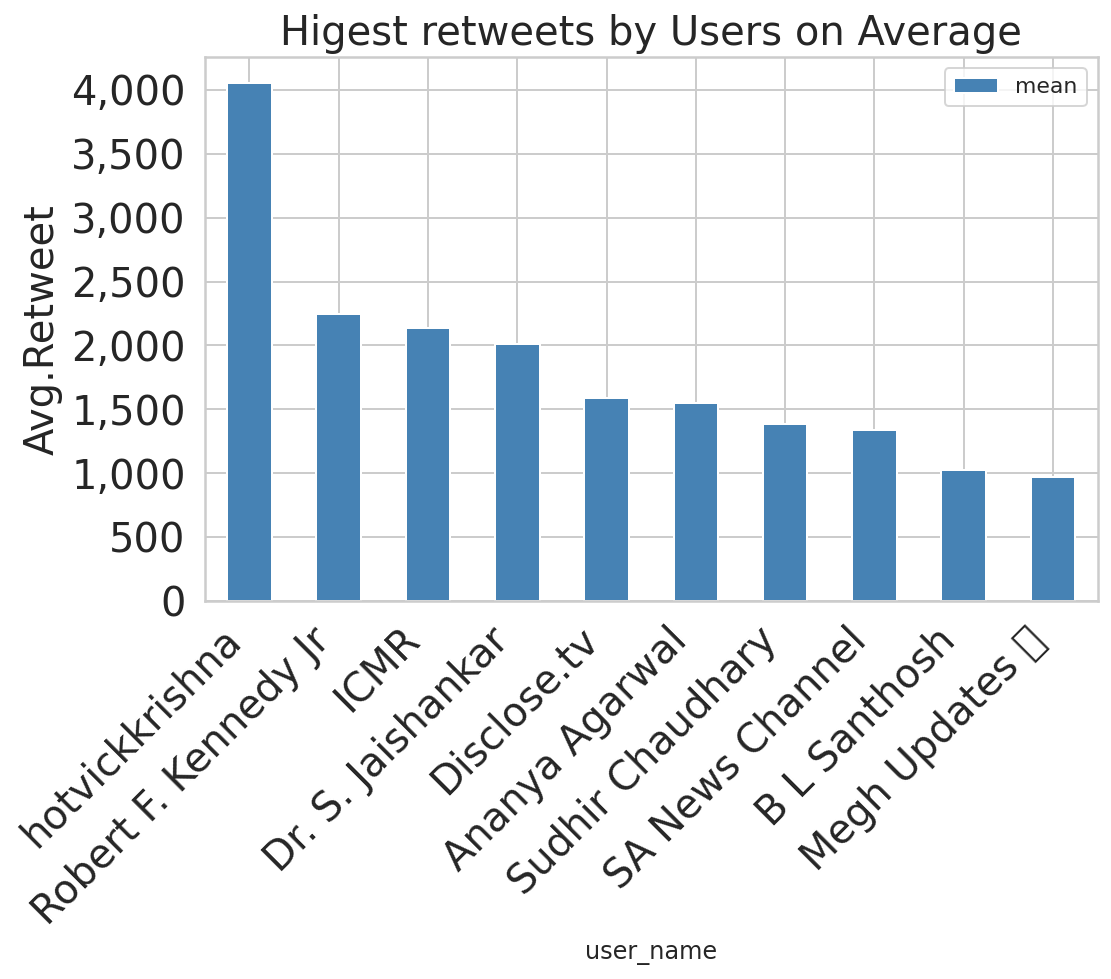

In [17]:
# group by username that has highest retweets on average
# specify column 'retweets' for aggregating in groupby 

#df1 = df[df["user_name"].isin(['Sputnik V', 'ICMR'])]


#df1 = df[["user_name", "retweets"]].groupby('user_name')['retweets'].agg(['mean', 'count']).sort_values(by = 'mean', ascending=[False])
df1 = df[["user_name", "retweets"]].groupby('user_name')['retweets'].agg(['mean']).sort_values(by = 'mean', ascending=[False])
#df1['retweets'] = df1.apply(lambda x: "{:,}".format(x['retweets']), axis=1)
df1_top10_retweets = df1[0:10]
df1_top10_retweets


# Plot Results
fig, ax = plt.subplots(1, 1)
df1_top10_retweets.plot(kind='bar', color = 'steelblue', figsize=(8,5),ax=ax)
plt.xticks(rotation=45, horizontalalignment='right', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Avg.Retweet', fontsize=20)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.title('Higest retweets by Users on Average', fontsize=20)

User Verification Summary

<AxesSubplot:xlabel='user_verified'>

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

(array([     0.,  25000.,  50000.,  75000., 100000., 125000., 150000.,
        175000., 200000., 225000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0, 0.5, 'User Verification')

Text(0.5, 1.0, 'User Verification Counts in this dataset')

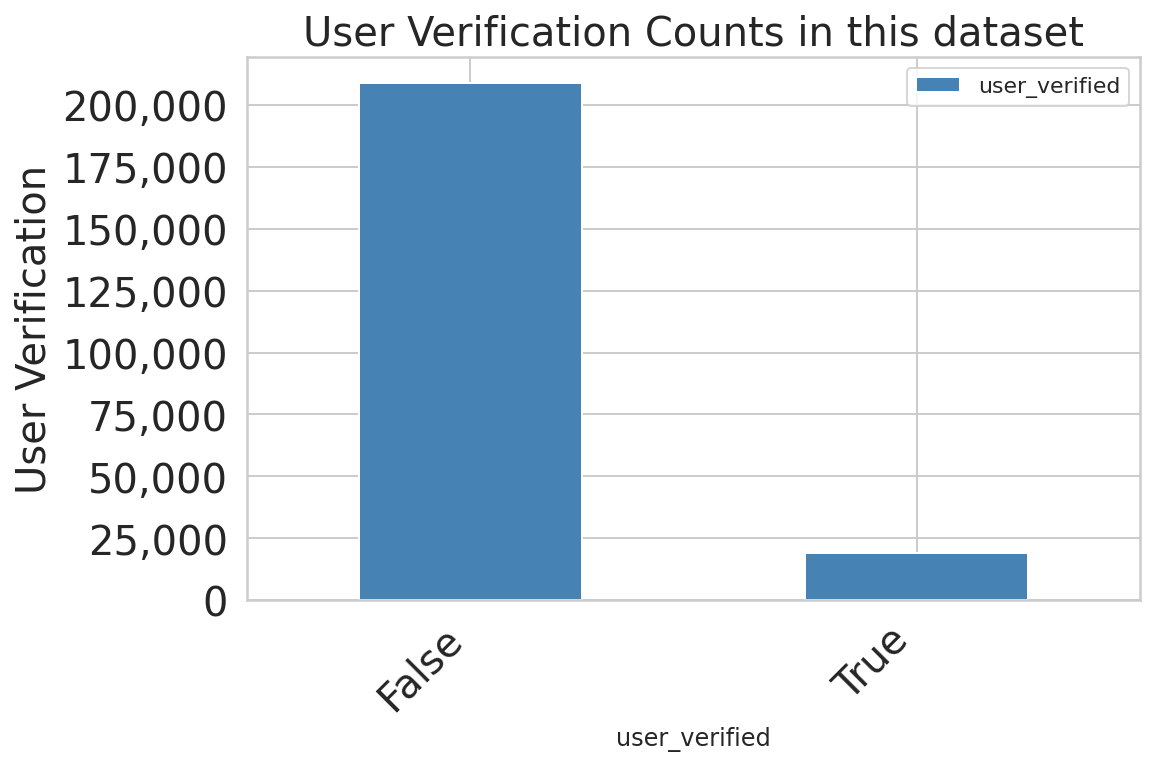

In [18]:
# group by user verified and see how many of the records are verified

df_verification = df.groupby(['user_verified'])[["user_verified"]].count()

# Plot Results
fig, ax = plt.subplots(1, 1)
df_verification.plot(kind='bar', color = 'steelblue', figsize=(8,5),ax=ax)
plt.xticks(rotation=45, horizontalalignment='right', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('User Verification', fontsize=20)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.title('User Verification Counts in this dataset', fontsize=20)

As seen, most of users in the dataset are not a verifier tweeter user.

Count of Tweet by Month (Year/Month)

# Step 6: Preprocessing Text

In [19]:
# Exam 'Text' Column 

type(df[['user_name','text']].head(10))
df[['user_name','text']][:4]

pandas.core.frame.DataFrame

,user_name,text
0,Rachel Roh,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF
1,Albert Fong,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm"
2,eli🇱🇹🇪🇺👌,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
3,Charles Adler,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4"


### Step 1: Tokenization, POS Tagging (Part of Speech) and Frequency Distribution

OS Tagging (Parts of Speech Tagging) is a process to mark up the words in text format for a particular part of a speech based on its definition and context. It is responsible for text reading in a language and assigning some specific token (Parts of Speech) to each word. It is also called grammatical tagging.

##### Tokenization Method 1 (general) & 2 (specifically for twitter)

There are tokenizers written specifically for twitter text, see http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual


In [20]:
# Method 1 
df['tokenized_text'] = df['text'].str.lower().apply(word_tokenize) 
df[['text', 'tokenized_text']].head(5)

# Method 2
tt = TweetTokenizer()
df['tweettokenized_text'] = df['text'].str.lower().apply(tt.tokenize)
df[['text', 'tokenized_text', 'tweettokenized_text']].head(5)

,text,tokenized_text
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,"[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, #, pfizerbiontech, https, :, //t.co/xehhimg1kf]"
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm","[while, the, world, has, been, on, the, wrong, side, of, history, this, year, ,, hopefully, ,, the, biggest, vaccination, effort, we, 've, ev…, https, :, //t.co/dlchrzjkhm]"
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"[#, coronavirus, #, sputnikv, #, astrazeneca, #, pfizerbiontech, #, moderna, #, covid_19, russian, vaccine, is, created, to, last, 2-4, years…, https, :, //t.co/ieylckbr8p]"
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4","[facts, are, immutable, ,, senator, ,, even, when, you, 're, not, ethically, sturdy, enough, to, acknowledge, them, ., (, 1, ), you, were, born, i…, https, :, //t.co/jqgv18kch4]"
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"[explain, to, me, again, why, we, need, a, vaccine, @, borisjohnson, @, matthancock, #, whereareallthesickpeople, #, pfizerbiontech…, https, :, //t.co/kxbsrobehq]"


,text,tokenized_text,tweettokenized_text
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,"[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, #, pfizerbiontech, https, :, //t.co/xehhimg1kf]","[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, #pfizerbiontech, https://t.co/xehhimg1kf]"
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm","[while, the, world, has, been, on, the, wrong, side, of, history, this, year, ,, hopefully, ,, the, biggest, vaccination, effort, we, 've, ev…, https, :, //t.co/dlchrzjkhm]","[while, the, world, has, been, on, the, wrong, side, of, history, this, year, ,, hopefully, ,, the, biggest, vaccination, effort, we've, ev, …, https://t.co/dlchrzjkhm]"
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"[#, coronavirus, #, sputnikv, #, astrazeneca, #, pfizerbiontech, #, moderna, #, covid_19, russian, vaccine, is, created, to, last, 2-4, years…, https, :, //t.co/ieylckbr8p]","[#coronavirus, #sputnikv, #astrazeneca, #pfizerbiontech, #moderna, #covid_19, russian, vaccine, is, created, to, last, 2-4, years, …, https://t.co/ieylckbr8p]"
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4","[facts, are, immutable, ,, senator, ,, even, when, you, 're, not, ethically, sturdy, enough, to, acknowledge, them, ., (, 1, ), you, were, born, i…, https, :, //t.co/jqgv18kch4]","[facts, are, immutable, ,, senator, ,, even, when, you're, not, ethically, sturdy, enough, to, acknowledge, them, ., (, 1, ), you, were, born, i, …, https://t.co/jqgv18kch4]"
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"[explain, to, me, again, why, we, need, a, vaccine, @, borisjohnson, @, matthancock, #, whereareallthesickpeople, #, pfizerbiontech…, https, :, //t.co/kxbsrobehq]","[explain, to, me, again, why, we, need, a, vaccine, @borisjohnson, @matthancock, #whereareallthesickpeople, #pfizerbiontech, …, https://t.co/kxbsrobehq]"


As shown, TweetTokenizer is doing a better job in breaking down tweets. hashtag, hyperlinks are grouped together

##### Tokenization &  POS

In [21]:
# 1: Dump the tokenized text into a list of string:
# df['text'].apply(word_tokenize).tolist()

# 2: Then use pos_tag_sents:
#pos_tag_sents(df['Text'].apply(word_tokenize).tolist())


# 3: Convert the list and add the column back to the DataFrame:

df['POS'] = pos_tag_sents(df['text'].str.lower().apply(word_tokenize).tolist()) # Method 1 
df['Tweet_POS'] = pos_tag_sents(df['text'].str.lower().apply(tt.tokenize).tolist()) # Method 2 (Tweet Tokenizer)

##### Tokenization & POS Comparison  between the two methods

In [22]:
df[['text', 'tokenized_text', 'tweettokenized_text', 'POS', 'Tweet_POS']].head(5)

,text,tokenized_text,tweettokenized_text,POS,Tweet_POS
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,"[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, #, pfizerbiontech, https, :, //t.co/xehhimg1kf]","[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, #pfizerbiontech, https://t.co/xehhimg1kf]","[(same, JJ), (folks, NNS), (said, VBD), (daikon, JJ), (paste, NN), (could, MD), (treat, VB), (a, DT), (cytokine, NN), (storm, NN), (#, #), (pfizerbiontech, JJ), (https, NN), (:, :), (//t.co/xehhimg1kf, NN)]","[(same, JJ), (folks, NNS), (said, VBD), (daikon, JJ), (paste, NN), (could, MD), (treat, VB), (a, DT), (cytokine, NN), (storm, NN), (#pfizerbiontech, NN), (https://t.co/xehhimg1kf, NN)]"
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm","[while, the, world, has, been, on, the, wrong, side, of, history, this, year, ,, hopefully, ,, the, biggest, vaccination, effort, we, 've, ev…, https, :, //t.co/dlchrzjkhm]","[while, the, world, has, been, on, the, wrong, side, of, history, this, year, ,, hopefully, ,, the, biggest, vaccination, effort, we've, ev, …, https://t.co/dlchrzjkhm]","[(while, IN), (the, DT), (world, NN), (has, VBZ), (been, VBN), (on, IN), (the, DT), (wrong, JJ), (side, NN), (of, IN), (history, NN), (this, DT), (year, NN), (,, ,), (hopefully, RB), (,, ,), (the, DT), (biggest, JJS), (vaccination, NN), (effort, NN), (we, PRP), ('ve, VBP), (ev…, VBN), (https, NN), (:, :), (//t.co/dlchrzjkhm, NN)]","[(while, IN), (the, DT), (world, NN), (has, VBZ), (been, VBN), (on, IN), (the, DT), (wrong, JJ), (side, NN), (of, IN), (history, NN), (this, DT), (year, NN), (,, ,), (hopefully, RB), (,, ,), (the, DT), (biggest, JJS), (vaccination, NN), (effort, NN), (we've, NN), (ev, VBP), (…, CD), (https://t.co/dlchrzjkhm, NN)]"
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"[#, coronavirus, #, sputnikv, #, astrazeneca, #, pfizerbiontech, #, moderna, #, covid_19, russian, vaccine, is, created, to, last, 2-4, years…, https, :, //t.co/ieylckbr8p]","[#coronavirus, #sputnikv, #astrazeneca, #pfizerbiontech, #moderna, #covid_19, russian, vaccine, is, created, to, last, 2-4, years, …, https://t.co/ieylckbr8p]","[(#, #), (coronavirus, NN), (#, #), (sputnikv, JJ), (#, #), (astrazeneca, JJ), (#, #), (pfizerbiontech, JJ), (#, #), (moderna, JJ), (#, #), (covid_19, JJ), (russian, JJ), (vaccine, NN), (is, VBZ), (created, VBN), (to, TO), (last, JJ), (2-4, JJ), (years…, NN), (https, NN), (:, :), (//t.co/ieylckbr8p, NN)]","[(#coronavirus, NN), (#sputnikv, NNP), (#astrazeneca, NNP), (#pfizerbiontech, NNP), (#moderna, NNP), (#covid_19, NNP), (russian, JJ), (vaccine, NN), (is, VBZ), (created, VBN), (to, TO), (last, JJ), (2-4, JJ), (years, NNS), (…, VBP), (https://t.co/ieylckbr8p, NN)]"
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4","[facts, are, immutable, ,, senator, ,, even, when, you, 're, not, ethically, sturdy, enough, to, acknowledge, them, ., (, 1, ), you, were, born, i…, https, :, //t.co/jqgv18kch4]","[facts, are, immutable, ,, senator, ,, even, when, you're, not, ethically, sturdy, enough, to, acknowledge, them, ., (, 1, ), you, were, born, i, …, https://t.co/jqgv18kch4]","[(facts, NNS), (are, VBP), (immutable, JJ), (,, ,), (senator, NN), (,, ,), (even, RB), (when, WRB), (you, PRP), ('re, VBP), (not, RB), (ethically, RB), (sturdy, JJ), (enough, RB), (to, TO), (acknowledge, VB), (them, PRP), (., .), ((, (), (1, CD), (), )), (you, PRP), (were, VBD), (born, VBN), (i…, JJ), (https, NN), (:, :), (//t.co/jqgv18kch4, NN)]","[(facts, NNS), (are, VBP), (immutable, JJ), (,, ,), (senator, NN), (,, ,), (even, RB), (when, WRB), (you're, NN), (not, RB), (ethically, RB), (sturdy, JJ), (enough, RB),

As shown, applying tweetokenizer is more appropriate than using general version in the context.

### Top Appeared Word Frequency Distribution

In [23]:
top_N = 10

# Need str.cat with lower first for concanecate all values to one string
lower_texts = df['text'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(lower_texts)
word_dist = nltk.FreqDist(words)
print (word_dist)

df_word_cnts_reslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])
df_word_cnts_reslt

<FreqDist with 339451 samples and 5358295 outcomes>


,Word,Frequency
0,#,420751
1,:,277170
2,https,194902
3,",",134075
4,@,122306
5,the,92732
6,.,78155
7,covaxin,76155
8,of,61510
9,to,60599


Majority of the tweets contains stopswords that are not interesting for analysis. The next step is to start produce a more 'clean' version of the text for further analysis and visualization


### Step 2: Preprocess 'Text', remove hashtags, https, emoji, number, punctuation

In [24]:
#text = "welcome to the jungle"
#x = text.split()
#print(x)

#txt = "hello, my name is Peter, I am 26 years old"
#x = txt.split(",")
#print(x)

#result = re.sub('abc',  '',    input)           # Delete pattern abc
#result = re.sub('abc',  'def', input)           # Replace pattern abc -> def
#result = re.sub(r'\s+', ' ',   input)           # Eliminate duplicate whitespaces using wildcards
#result = re.sub('abc(def)ghi', r'\1', input)    # Replace a string with a part of itself

#### Define Preprocessed Text Functions
Use different types of regular expression to perform text preprocessing

In [25]:
# Remove puncutations, hashtag, hyperlink, @ mention and Emoji 

def preprocessed_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'{re.escape(punctuation)}', '', text)  # Remove punctuation
    #text = re.sub(r'\W', ' ', str([text])) # Remove all the special characters
    #text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # remove all single characters
    #text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) # Remove single characters from the start
    text = re.sub(r'\d+', '', text) # remove numbers
    #text = re.sub(r'[^\w\s]', '', text) # removes punctuations in string --- it will make http as string instead of removing the http
    text = re.sub('\s+', ' ', text).strip() # removes leading and trailing whitespaces
    text = " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", '', text).split()) # remove hashtag, hyperlinks and @ mention
    text = " ".join(text.split())  # Remove extra spaces, tabs, and new lines
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', str(text))  # need to change it to strings before passing it to re.sub

#### Apply 'preprocessed_text' Function on 'text' column to create new 'clean_text' column for Tweet Tokenization and Tweet POS 

In [26]:
type(df['text'])

df['clean_text'] = df["text"].str.lower().map(preprocessed_text)

# Apply preprocessed_text Function and Tokenized Clean text -- in this case, since we use tweets, we go ahead with tweet tokenization
tt = TweetTokenizer()
df['clean_tweettokenized_text'] = df['clean_text'].apply(tt.tokenize)

#Convert the above tokenized text into a list and add the list column back to the DataFrame
df['clean_Tweet_POS'] = pos_tag_sents(df['clean_tweettokenized_text'].tolist())

pandas.core.series.Series

### Step 3:  Remove Stopwords in 'clean text' and 'clean_tweettokenized_text' column

In [27]:
eng_stopwords = stopwords.words('english') 

df['clean_tweettokenized_text_rmstopwds'] = df['clean_tweettokenized_text'].apply(lambda words: [word for word in words if word not in eng_stopwords])

Review Modified Dataframe 

In [28]:
df[['text', 'clean_text' , 'tokenized_text', 'tweettokenized_text', 'clean_tweettokenized_text', 'clean_tweettokenized_text_rmstopwds', 'POS', 'Tweet_POS', 'clean_Tweet_POS']].head(3)

,text,clean_text,tokenized_text,tweettokenized_text,clean_tweettokenized_text,clean_tweettokenized_text_rmstopwds,POS,Tweet_POS,clean_Tweet_POS
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,same folks said daikon paste could treat a cytokine storm pfizerbiontech,"[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, #, pfizerbiontech, https, :, //t.co/xehhimg1kf]","[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, #pfizerbiontech, https://t.co/xehhimg1kf]","[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, pfizerbiontech]","[folks, said, daikon, paste, could, treat, cytokine, storm, pfizerbiontech]","[(same, JJ), (folks, NNS), (said, VBD), (daikon, JJ), (paste, NN), (could, MD), (treat, VB), (a, DT), (cytokine, NN), (storm, NN), (#, #), (pfizerbiontech, JJ), (https, NN), (:, :), (//t.co/xehhimg1kf, NN)]","[(same, JJ), (folks, NNS), (said, VBD), (daikon, JJ), (paste, NN), (could, MD), (treat, VB), (a, DT), (cytokine, NN), (storm, NN), (#pfizerbiontech, NN), (https://t.co/xehhimg1kf, NN)]","[(same, JJ), (folks, NNS), (said, VBD), (daikon, JJ), (paste, NN), (could, MD), (treat, VB), (a, DT), (cytokine, NN), (storm, NN), (pfizerbiontech, NN)]"
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",while the world has been on the wrong side of history this year hopefully the biggest vaccination effort weve ev,"[while, the, world, has, been, on, the, wrong, side, of, history, this, year, ,, hopefully, ,, the, biggest, vaccination, effort, we, 've, ev…, https, :, //t.co/dlchrzjkhm]","[while, the, world, has, been, on, the, wrong, side, of, history, this, year, ,, hopefully, ,, the, biggest, vaccination, effort, we've, ev, …, https://t.co/dlchrzjkhm]","[while, the, world, has, been, on, the, wrong, side, of, history, this, year, hopefully, the, biggest, vaccination, effort, weve, ev]","[world, wrong, side, history, year, hopefully, biggest, vaccination, effort, weve, ev]","[(while, IN), (the, DT), (world, NN), (has, VBZ), (been, VBN), (on, IN), (the, DT), (wrong, JJ), (side, NN), (of, IN), (history, NN), (this, DT), (year, NN), (,, ,), (hopefully, RB), (,, ,), (the, DT), (biggest, JJS), (vaccination, NN), (effort, NN), (we, PRP), ('ve, VBP), (ev…, VBN), (https, NN), (:, :), (//t.co/dlchrzjkhm, NN)]","[(while, IN), (the, DT), (world, NN), (has, VBZ), (been, VBN), (on, IN), (the, DT), (wrong, JJ), (side, NN), (of, IN), (history, NN), (this, DT), (year, NN), (,, ,), (hopefully, RB), (,, ,), (the, DT), (biggest, JJS), (vaccination, NN), (effort, NN), (we've, NN), (ev, VBP), (…, CD), (https://t.co/dlchrzjkhm, NN)]","[(while, IN), (the, DT), (world, NN), (has, VBZ), (been, VBN), (on, IN), (the, DT), (wrong, JJ), (side, NN), (of, IN), (history, NN), (this, DT), (year, NN), (hopefully, RB), (the, DT), (biggest, JJS), (vaccination, NN), (effort, NN), (weve, VBP), (ev, NN)]"
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,coronavirus sputnikv astrazeneca pfizerbiontech moderna covid russian vaccine is created to last years,"[#, coronavirus, #, sputnikv, #, astrazeneca, #, pfizerbiontech, #, moderna, #, covid_19, russian, vaccine, is, created, to, last, 2-4, years…, https, :, //t.co/ieylckbr8p]","[#coronavirus, #sputnikv, #astrazeneca, #pfizerbiontech, #moderna, #covid_19, russian, vaccine, is, created, to, last, 2-4, years, …, https://t.co/ieylckbr8p]","[coronavirus, sputnikv, astrazeneca, pfizerbiontech, moderna, covid, russian, vaccine, is, created, to, last, years]","[coronavirus, sputnikv, astrazeneca, pfizerbiontech, moderna, covid, russian, vaccine, created, last, years]","[(#, #), (coronavirus, NN), (#, #), (sputnikv, JJ), (#, #), (astrazeneca, JJ), (#, #), (pfizerbiontech, JJ), (#, #), (moderna, JJ), (#, #), (covid_19, JJ), (russian, JJ), (vaccine, N

####  Recalculate Frequency Distribution on 'clean_text' column 


In [29]:
top_N = 10

# Need str.cat with lower first for concanecate all values to one string

concat_texts = df['clean_text'].str.cat(sep=' ') # already lower case, we just need to concat into one string
#concat_texts

words = nltk.tokenize.word_tokenize(concat_texts)
word_dist = nltk.FreqDist(words)
print(word_dist)


# Plot Results
df_word_cnts_reslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])
df_word_cnts_reslt

<FreqDist with 77445 samples and 3218739 outcomes>


,Word,Frequency
0,the,95129
1,covaxin,75771
2,of,63094
3,to,61809
4,vaccine,55331
5,and,52255
6,dose,51205
7,moderna,49431
8,for,45508
9,covid,43212


### Step 4: Lexicon Normalization (Stemming & Lemmatization)

Nornmalizes a word by reducing it to its most basic element or stem. Removing affixes, plurals, and normalizing verb tenses

Reducing number of unique tokens, simplifying subsequent processing steps

Lemmatization reduces words to their base word, which is linguistically correct lemmas. It transforms root word with the use of vocabulary and morphological analysis. Lemmatization is usually more sophisticated than stemming. Stemmer works on an individual word without knowledge of the context.

Porter, Snowball (superior to Porter), Lancaster(very aggresive, used with care)


#### Porter and Snowball Stemming

In [30]:
################################################################################
# Method 1: Porter Stemmer from NLTK to stem the words on df.clean_tweettokenized_text

ps = PorterStemmer()

#def ps_stem_sentences(tokens):
 #   stemmed_tokens = [ps.stem(token) for token in tokens]
 #   return stemmed_tokens #' '.join(stemmed_tokens) # get back the tweet into sentence format 

#df['clean_ps_stemmed'] = df['clean_tweettokenized_text_rmstopwds'].apply(ps_stem_sentences)



df['clean_ps_stemmed'] = df['clean_tweettokenized_text_rmstopwds'].apply(lambda tokens: [ps.stem(y) for y in tokens])
#type(df['clean_ps_stemmed'])
#df['clean_ps_stemmed'].dtypes




################################################################################
# Method 2: Snowball Stemmer

snow_stemmer = SnowballStemmer(language='english') #define stemming dict

df['clean_snow_stemmed'] = df['clean_tweettokenized_text_rmstopwds'].apply(lambda x: [snow_stemmer.stem(y) for y in x]) # Stem every word.
#type(df['clean_snow_stemmed'])
#df['clean_snow_stemmed'].dtypes

#### Lexicon Normalization

In [31]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

df['clean_lem'] = df['clean_tweettokenized_text_rmstopwds'].apply(lambda x: [lem.lemmatize(y) for y in x]) # Lemmatize every word.
type(df['clean_lem'])
df['clean_lem'].dtypes

pandas.core.series.Series

dtype('O')

In [32]:
# Review Modified Dataframe 
df[['text', 'clean_text' , 'tokenized_text', 'tweettokenized_text', 'clean_tweettokenized_text', 'clean_tweettokenized_text_rmstopwds', 'clean_ps_stemmed', 'clean_snow_stemmed', 'clean_lem']].head(3)

,text,clean_text,tokenized_text,tweettokenized_text,clean_tweettokenized_text,clean_tweettokenized_text_rmstopwds,clean_ps_stemmed,clean_snow_stemmed,clean_lem
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,same folks said daikon paste could treat a cytokine storm pfizerbiontech,"[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, #, pfizerbiontech, https, :, //t.co/xehhimg1kf]","[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, #pfizerbiontech, https://t.co/xehhimg1kf]","[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, pfizerbiontech]","[folks, said, daikon, paste, could, treat, cytokine, storm, pfizerbiontech]","[folk, said, daikon, past, could, treat, cytokin, storm, pfizerbiontech]","[folk, said, daikon, past, could, treat, cytokin, storm, pfizerbiontech]","[folk, said, daikon, paste, could, treat, cytokine, storm, pfizerbiontech]"
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",while the world has been on the wrong side of history this year hopefully the biggest vaccination effort weve ev,"[while, the, world, has, been, on, the, wrong, side, of, history, this, year, ,, hopefully, ,, the, biggest, vaccination, effort, we, 've, ev…, https, :, //t.co/dlchrzjkhm]","[while, the, world, has, been, on, the, wrong, side, of, history, this, year, ,, hopefully, ,, the, biggest, vaccination, effort, we've, ev, …, https://t.co/dlchrzjkhm]","[while, the, world, has, been, on, the, wrong, side, of, history, this, year, hopefully, the, biggest, vaccination, effort, weve, ev]","[world, wrong, side, history, year, hopefully, biggest, vaccination, effort, weve, ev]","[world, wrong, side, histori, year, hope, biggest, vaccin, effort, weve, ev]","[world, wrong, side, histori, year, hope, biggest, vaccin, effort, weve, ev]","[world, wrong, side, history, year, hopefully, biggest, vaccination, effort, weve, ev]"
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,coronavirus sputnikv astrazeneca pfizerbiontech moderna covid russian vaccine is created to last years,"[#, coronavirus, #, sputnikv, #, astrazeneca, #, pfizerbiontech, #, moderna, #, covid_19, russian, vaccine, is, created, to, last, 2-4, years…, https, :, //t.co/ieylckbr8p]","[#coronavirus, #sputnikv, #astrazeneca, #pfizerbiontech, #moderna, #covid_19, russian, vaccine, is, created, to, last, 2-4, years, …, https://t.co/ieylckbr8p]","[coronavirus, sputnikv, astrazeneca, pfizerbiontech, moderna, covid, russian, vaccine, is, created, to, last, years]","[coronavirus, sputnikv, astrazeneca, pfizerbiontech, moderna, covid, russian, vaccine, created, last, years]","[coronaviru, sputnikv, astrazeneca, pfizerbiontech, moderna, covid, russian, vaccin, creat, last, year]","[coronavirus, sputnikv, astrazeneca, pfizerbiontech, moderna, covid, russian, vaccin, creat, last, year]","[coronavirus, sputnikv, astrazeneca, pfizerbiontech, moderna, covid, russian, vaccine, created, last, year]"


# Step 7: Visualization - Word Cloud

WordCloud is a technique to show which words are the most frequent among the given text.

Reference 1:
https://www.datacamp.com/community/tutorials/wordcloud-python

Reference 2: Generate word cloud from tokenized word_dist
https://stackoverflow.com/questions/55975609/how-can-i-generate-a-word-cloud-from-tokenized-words-in-python

### Create test word cloud using first tweet of dataframe

pandas.core.series.Series

(-0.5, 399.5, 199.5, -0.5)

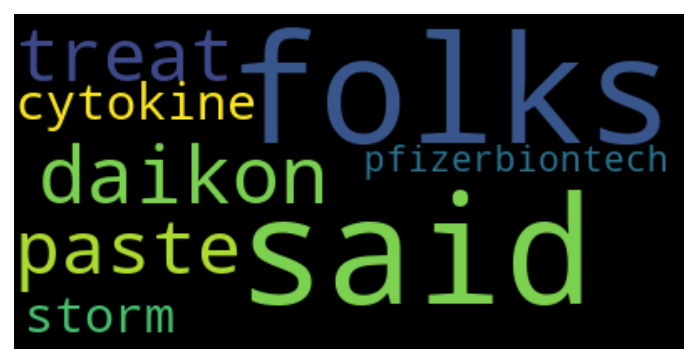

<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

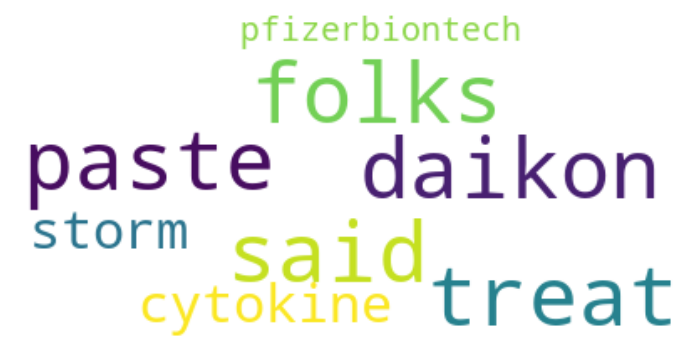

In [33]:
#?WordCloud

################################################################################
# 1: Start with one review from 'df['clean_text']' and We need to Convert Series to Dataframe 

#pd_df_remove_1 = pd.DataFrame(df['clean_text'])
#type(pd_df_remove_1) #pandas.core.frame.DataFrame
#text = pd_df_remove_1.clean_text[0] # first row of text in the dataframe 
#text

################################################################################
# 2: Create and generate a word cloud image:
#wordcloud = WordCloud().generate(text) #refer to step 1

# However, we need to apply clean Tweet tokenized words from above steps (ones with stopwords as we can use word cloud stopswords to remove them)
# generate_from_text expects a string, if you have all your words in a list as is the case in tokenized_word then you can turn that into text easily using ' '.join(tokenized_word)

type(df['clean_tweettokenized_text'])
wordcloud = WordCloud().generate_from_text(' '.join(df['clean_tweettokenized_text'][0]))


################################################################################
# 3:  Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

################################################################################
# 4: lower max_font_size, change the maximum number of word and lighten the background:
#wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text) # refer to step 1
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_text(' '.join(df['clean_tweettokenized_text'][0])) # refer to clean tweet tokens
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")# This is to make the displayed image appear more smoothly.
plt.axis("off")
plt.show()

################################################################################
# 5: Save the image in the img folder
wordcloud.to_file("/home/AC27802/first_review.png")

# Word Count Summary

In [34]:
lst= df['text'].tolist()
lst[:3]

['Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF',
 "While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",
 '#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P']

In [35]:
#type(df['clean_tweettokenized_text']) #pandas.core.series.Series
#type(df[['clean_tweettokenized_text', 'clean_Tweet_POS']]) #pandas.core.frame.DataFrame


# need to count number of elements in the clean_tweettokenized_text column
list0 = df['text'][0]
list1 = df['tokenized_text'][0]
list2 = df['tweettokenized_text'][0]
list3 = df['clean_tweettokenized_text'][0]
len(list0)
len(list1)
len(list2)
len(list3)

    
# df[['user_name', 'retweets', 'user_verified']][0:3]
for label, row in df[['user_name', 'retweets', 'user_verified']][0:3].iterrows():
    print(label)
    print(row)
    
# calculate number of string in a cell for each row in the column 
#df['tweettokenized_text'].apply(lambda x: len(str(x).split(' ')))

97

15

12

11

0
user_name        Rachel Roh
retweets                  0
user_verified         False
Name: 0, dtype: object
1
user_name        Albert Fong
retweets                   1
user_verified          False
Name: 1, dtype: object
2
user_name        eli🇱🇹🇪🇺👌
retweets                0
user_verified       False
Name: 2, dtype: object


In [36]:
################################################################################
# Combine all tweets into one big text (*String*) and create a big fat cloud 

text = " ".join(text for text in df.text)
print ("There are {} words in the combination of all text.".format(len(text)))
type(text)

cleaned_text = " ".join(text for text in df.clean_text) #df['clean_tweettokenized_text'] 
print ("There are {} words in the combination of all cleaned text.".format(len(cleaned_text)))
type(cleaned_text)

diff = len(text) - len(cleaned_text)
diff

################################################################################
# Convert a tokenized dataframe to string to generate a wordcloud (word cloud expects a string not a list!!!) 
clean_tweettokenized_text1 =  df['clean_tweettokenized_text'].to_string()
print ("There are {} words in the combination of all cleaned text.".format(len(clean_tweettokenized_text1)))
type(clean_tweettokenized_text1)

There are 28652651 words in the combination of all text.


str

There are 19588854 words in the combination of all cleaned text.


str

9063797

There are 39936224 words in the combination of all cleaned text.


str

### Apply WordCloud to All 'Clean' Tokenized Tweets in Dataframe

(-0.5, 399.5, 199.5, -0.5)

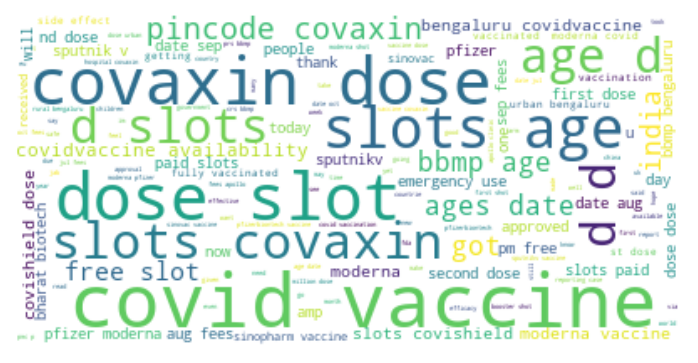

In [37]:
################################################################################
# Create stopword list:

# nltk.download("stopwords")
# stopwords = stopwords.words('english')
stopwords = set(STOPWORDS)
#stopwords

################################################################################
# Generate a word cloud image using clean_tweettokenized_text1
#wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(cleaned_text) # need to replace with below
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(clean_tweettokenized_text1) # refer above-- already turn into a string


################################################################################
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Step 8: Create Masked Wordcloud

Images are stored in the form of a matrix of numbers in a computer where these numbers are known as pixel values. These pixel values represent the intensity of each pixel. 0 represents black and 255 represents white.

Color code table: https://matplotlib.org/2.0.0/examples/color/named_colors.html

In [38]:
vaccine_mask = np.array(Image.open("/home/AC27802/vaccine_mask.png"))
vaccine_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [39]:
len(vaccine_mask)
vaccine_mask.shape
vaccine_mask.shape[0]
vaccine_mask.shape[1]
vaccine_mask.dtype
range(len(vaccine_mask))
#vaccine_mask[0]
#axis-0 discerns which of the 3 sheets to select from.
#axis-1 discerns which of number of rows, in any sheet, to select from.
#axis-2 discerns which of number of columns, in any sheet and row, to select from.

612

(612, 612)

612

612

dtype('uint8')

range(0, 612)

In [40]:
def transform_format(val):
    if val in (0, 246, 247, 248):
    #if val == 0:
        return 255
    else:
        return val

In [41]:
# Transform your mask into a new one that will work with the function:
transformed_vaccine_mask = np.ndarray((vaccine_mask.shape[0],vaccine_mask.shape[1]), np.int32)

#TypeError: 'list' object is not callable
#as you have defined 'list' as a variable earlier in the code!!!

for i in range(len(vaccine_mask)):
    transformed_vaccine_mask[i] = list(map(transform_format, vaccine_mask[i])) 

In [42]:
# Check the expected result of your mask

transformed_vaccine_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

<Figure size 1440x1152 with 0 Axes>

(-0.5, 611.5, 611.5, -0.5)

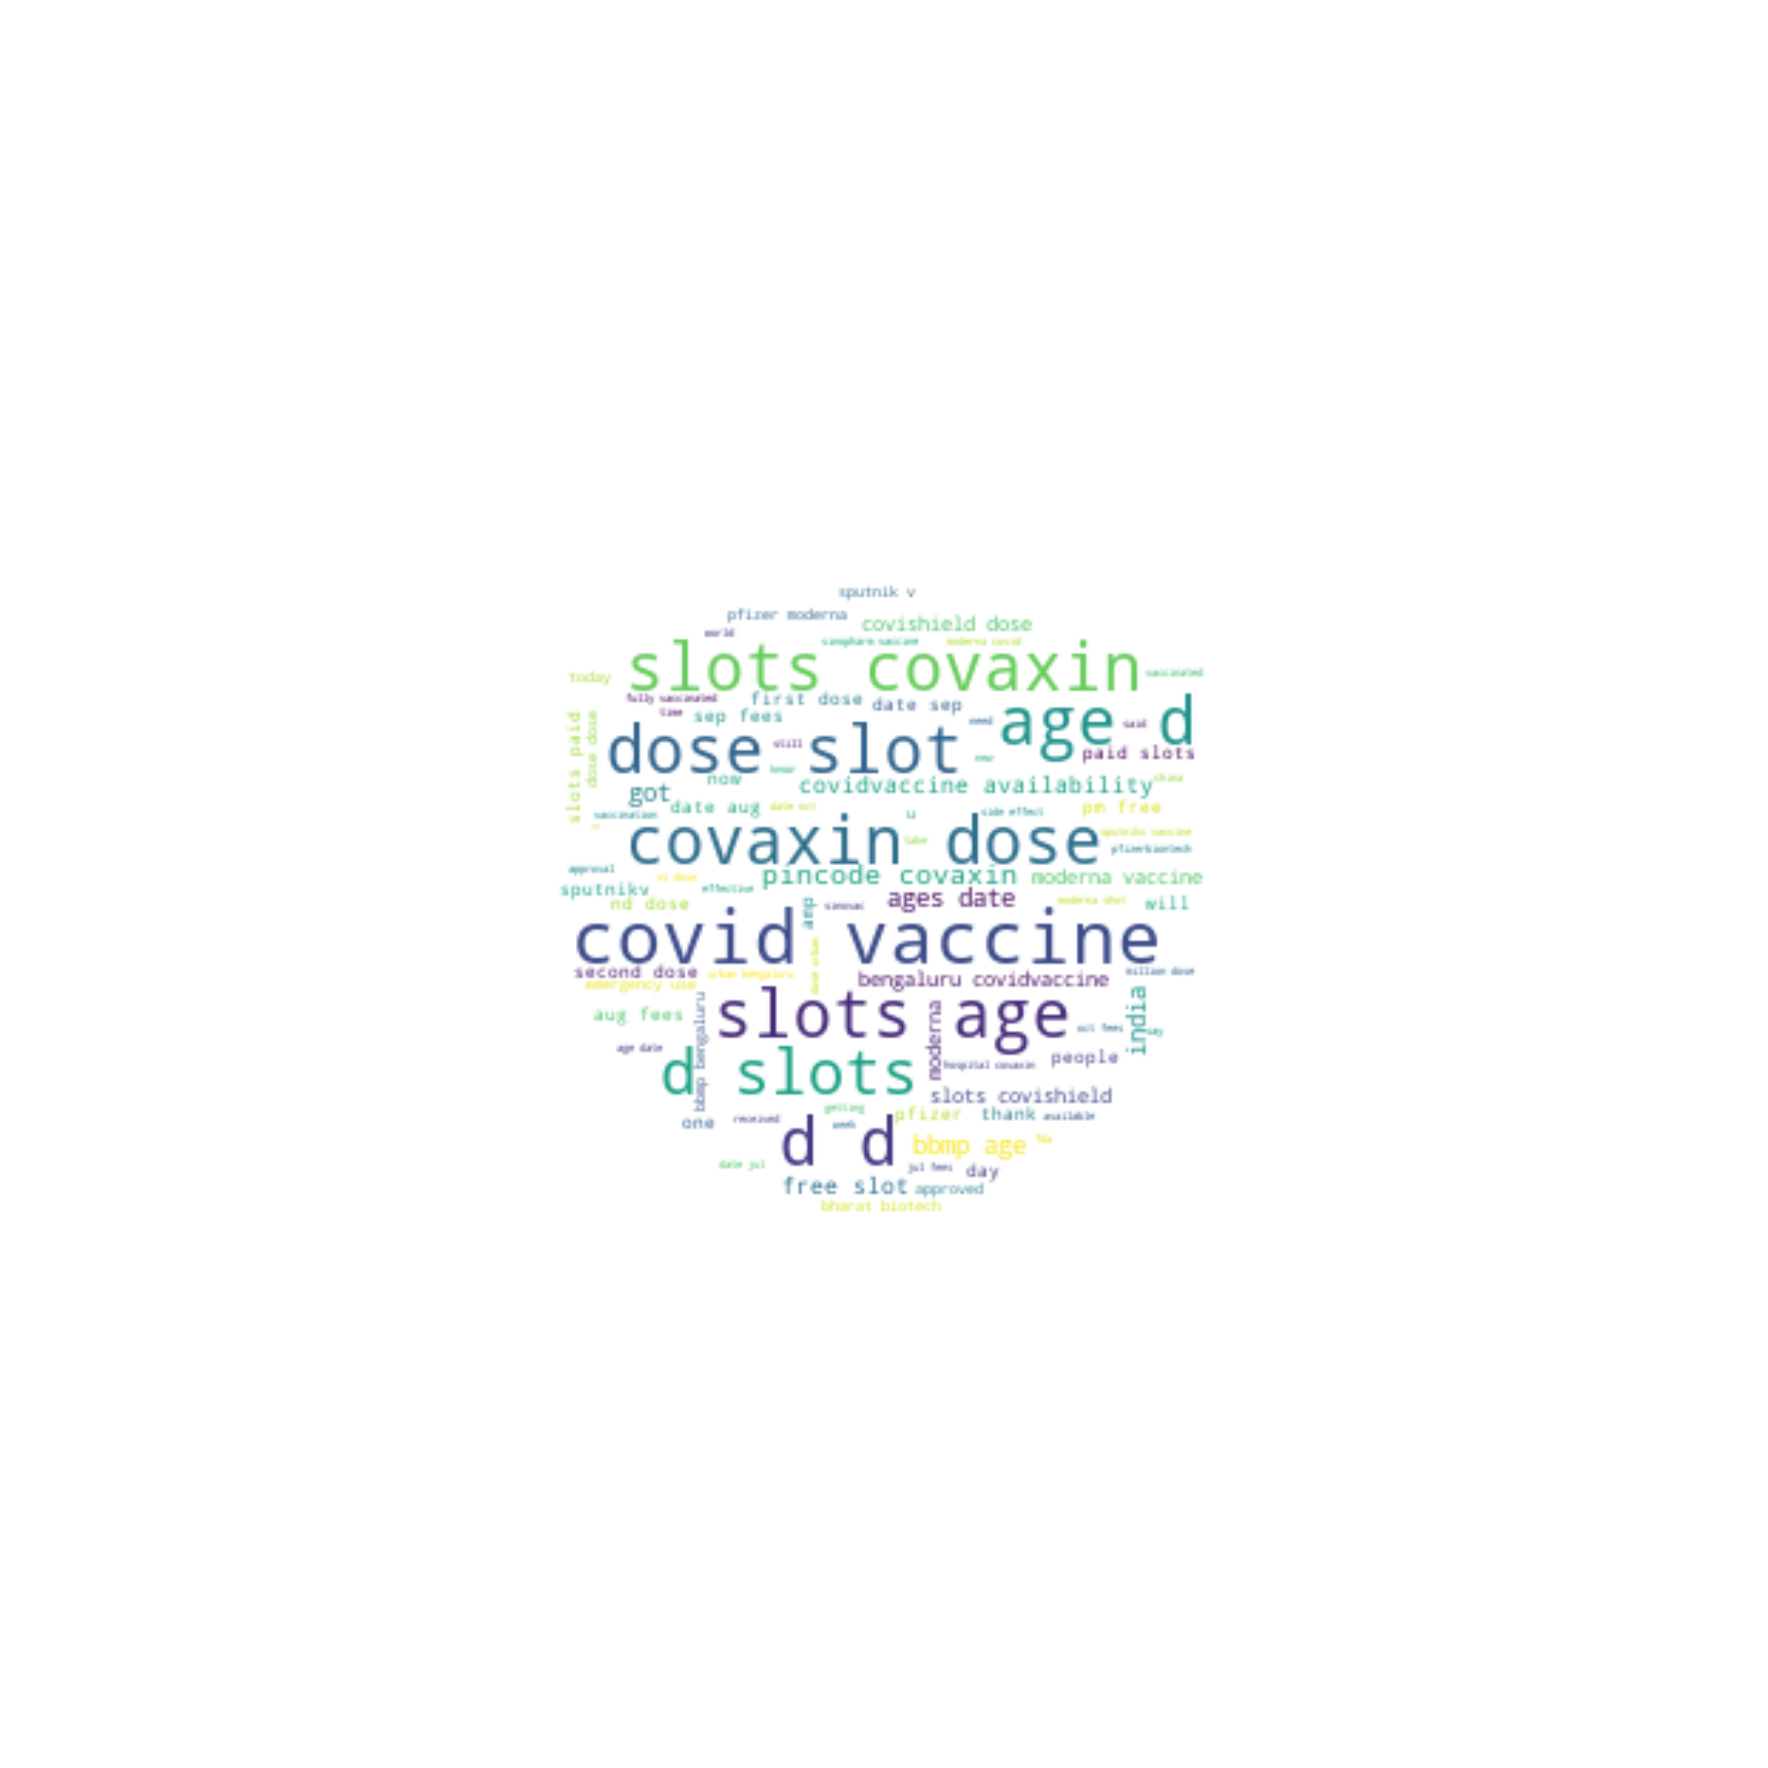

In [43]:
# Create a word cloud image
# https://www.pythonfixing.com/2021/10/fixed-wordcloud-with-text-from-column.html

wc = WordCloud(background_color="white", max_words=500, mask=transformed_vaccine_mask, #vaccine_mask
               stopwords=stopwords)

# Generate a wordcloud on tokenized text
wc.generate(clean_tweettokenized_text1)
#wc.generate(' '.join(df['clean_tweettokenized_text'].sum())) # refer to clean tweet tokens


# store to file
wc.to_file("/home/AC27802/first_masked_wordcloud.png")

# show
plt.figure(figsize=[20,16])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud is visual representation of most popular word based on frequency and relevance in given tweets.
We can see some most popular words are 'age', 'slots', 'vaccines', 'dose'

## There are mainly two approaches for performing sentiment analysis.

## Lexicon-based: count number of positive and negative words in given text and the larger count will be the sentiment of text.

## Machine learning based approach: Develop a classification model, which is trained using the pre-labeled dataset of positive, negative, and neutral.

## Sentiment analysis (opinion mining) is a text mining technique that uses machine learning and natural language processing (nlp) to automatically analyze text for the sentiment of the writer (positive, negative, neutral, and beyond)

# Step 9: Sentiment Analysis (TextBlob)


Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. 

Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

PatternAnalyzer - a default classifier that is built on the pattern library

NaiveBayesAnalyzer - an NLTK model trained on a movie reviews corpus

In [44]:
#!python -m textblob.download_corpora

In [45]:
#!pip install searchtweets

In [46]:
#TextBlob("I tested positive for COVID-19").sentiment

#blob = TextBlob("I love this library", analyzer=NaiveBayesAnalyzer())
#blob.sentiment

In [47]:
# Take a look at Converted Dataframe 
#df['clean_text'].head(2)

In [48]:
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

df['sentiment'] = df['clean_text'].apply(sentiment_calc)

In [49]:
#Create a function to get the subjectivity   
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
  
#Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# create two new column
df['polarity']=df['clean_text'].apply(getPolarity)
df['subjectivity']=df['clean_text'].apply(getSubjectivity)

In [50]:
#create function to compute positive, negative and neutral analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['analysis'] = df['polarity'].apply(getAnalysis)

In [51]:
#show new Dataframe
df[['date', 'user_name', 'text', 'clean_text', 'sentiment', 'polarity', 'subjectivity', 'analysis']].sort_values(by='date', ascending=False).head()

## positive Tweets in Dataframe
#df[df.analysis == 'Positive'][:3]

## show value counts
df['analysis'].value_counts()

,date,user_name,text,clean_text,sentiment,polarity,subjectivity,analysis
225290,2021-11-23 20:58:08,IsmosisJonesIX,Current status of #Covaxin @mikalche @B1llyTh2K3d https://t.co/YZh1vIJRrU,current status of covaxin,"(0.0, 0.4)",0.0,0.400,Neutral
223547,2021-11-23 20:57:54,globalEDGE,"The COVID-19 vaccine has been made available around the world. Now, COVID-19 booster shots have begun rolling out.… https://t.co/URtNusJtM3",the covid vaccine has been made available around the world now covid booster shots have begun rolling out,"(0.4, 0.4)",0.4,0.400,Positive
225291,2021-11-23 20:57:11,"Dr. A. K. Singh; MD, DM (Endo) 🇮🇳",A case control study from India found vaccine effectiveness of 50% with 2 doses of #Covaxin for delta strain! Just… https://t.co/Yb9ysbqBe9,a case control study from india found vaccine effectiveness of with doses of covaxin for delta strain just,"(0.0, 0.0)",0.0,0.000,Neutral
223548,2021-11-23 20:55:52,UNSCARED,Σｔｅｒｎｉｔｙ ｔｏ Ｆｌａｔｔｅｎ ｔｈｅ Ｃｕｒｖｅ ... \n\n😂😂😂 funny but true!\n\n#Pfizer\n#Moderna\n#johnsonandjohnson\n#AstraZeneca… https://t.co/Btg9b4icjR,funny but true pfizer moderna johnsonandjohnson astrazeneca,"(0.3, 0.825)",0.3,0.825,Positive
225292,2021-11-23 20:54:39,TexasNative,@snehamordani @BharatBiotech Eagerly anticipating! #COVAXIN,eagerly anticipating covaxin,"(0.0, 0.0)",0.0,0.000,Neutral


Neutral     123138
Positive     80447
Negative     24622
Name: analysis, dtype: int64

### Plotting Scatter Graph between Polarity and Subjectivity

In [52]:
## plot polarity and subjectivity

#plt.figure(figsize=(8,6))
#for i in range(0, df.shape[0]):
 #   plt.scatter(df['polarity'][i],df['subjectivity'][i],color='Blue')
#plt.title('Sentiment Analysis')
#plt.xlabel('Polarity')
#plt.ylabel('Subjectivity')
#plt.show()


#for index,row in df.iterrows():
 #   if row['analysis']=='Positive':
  #      plt.scatter(row['polarity'],row['subjectivity'],color='green')
 #   elif row['analysis']=='Negative':
   #     plt.scatter(row['polarity'],row['subjectivity'],color='red')
  #  else:
   #     plt.scatter(row['polarity'],row['subjectivity'],color='blue')
#plt.title('Sentiment Analysis')
#plt.xlabel('Polarity')
#plt.ylabel('Subjectivity')
#plt.show()

Red dots represents negetive tweets, Green dots represents positive tweets and remaining blue dots are neutral tweets.

80447

228207

Neutral     123138
Positive     80447
Negative     24622
Name: analysis, dtype: int64

Text(0.5, 1.0, 'Sentiment Analysis')

Text(0.5, 0, 'Sentiments')

Text(0, 0.5, 'Counts')

<AxesSubplot:title={'center':'Sentiment Analysis'}, xlabel='Sentiments', ylabel='Counts'>

(array([0, 1, 2]),
 [Text(0, 0, 'Neutral'), Text(1, 0, 'Positive'), Text(2, 0, 'Negative')])

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

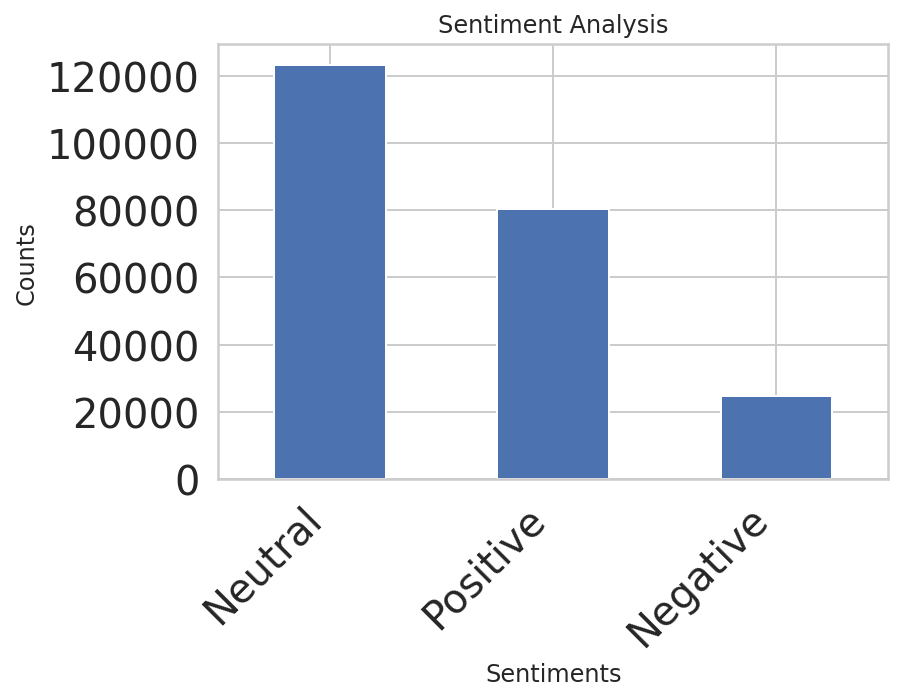

<AxesSubplot:xlabel='analysis', ylabel='count'>

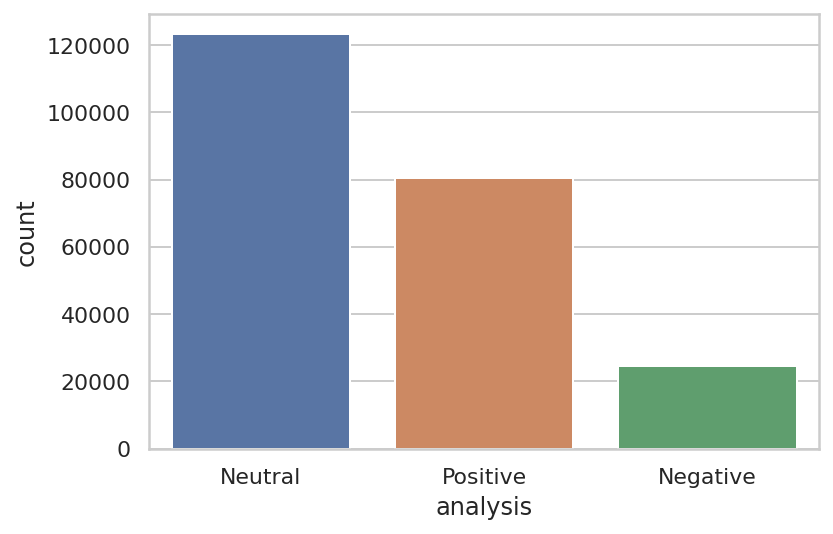

In [53]:
# Plot percentage of positive and negative tweets 

ptweets=df['clean_text'][df.analysis=='Positive'].shape[0]
ptweets
total_tweets = df.shape[0]
total_tweets

## show value counts
df['analysis'].value_counts()

## plot visulatisation of count
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments') 
plt.ylabel('Counts')
df['analysis'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=20)
plt.yticks(fontsize=20)
plt.show()


sns.countplot(x=df.analysis, data=df['analysis'], order = df['analysis'].value_counts().index)

Majority of tweets tend to be neutral on covid vaccine and also portions of the tweets are positive related. Only a small fractions tend to express negativitiy towards covid 19 vaccine. So let's try using a different analysis to see if the predominant sentiment has changed 

# Step 10:Sentiment Analysis (VADER)

**VADER not only tells the lexicon is positive, negative, or neutral, it also tells how positive, negative, or neutral a sentence is.

**The output from VADER comes in a Python dictionary in which we have four keys and their corresponding values. ‘neg’, ‘neu’, ‘pos’, and ‘compound’ which stands for Negative, Neutral, and Positive respectively. The Compound score is an indispensable score that is calculated by normalizing the other 3 scores (neg, neu, pos) between -1 and +1. The decision criteria are similar to TextBlob -1 is for most negative and +1 is for most positive.

VADER works better when it comes to negative sentiment classification.

In [54]:
analyzer = SentimentIntensityAnalyzer() # Create a SentimentIntensityAnalyzer object
df['vader_compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['clean_text']] #dtype('float64') as 'float' object is not iterable
df['vader_neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['clean_text']] # polarity_scores method of SentimentIntensityAnalyzer
df['vader_neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['clean_text']]
df['vader_pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['clean_text']]

In [55]:
type(df['vader_compound'])
df['vader_compound'].dtypes

pandas.core.series.Series

dtype('float64')

In [56]:
# function to print sentiments of the sentence
def vader_sentiment_scores(score):
    # decide sentiment as positive, negative and neutral based on compound column
    if score >= 0.05 :
        return 'Positive'
    elif score <= -0.05 :
        return 'Negative'
    else:
        return 'Neutral'

df['vader_analysis'] = df['vader_compound'].apply(vader_sentiment_scores)

In [57]:
#show new Dataframe
df[['date', 'user_name', 'text', 'clean_text', 'sentiment', 'polarity', 'subjectivity', 'analysis', 'vader_analysis', 'vader_compound', 'vader_neg', 'vader_neu', 'vader_pos']].sort_values(by='date', ascending=False).head(20)

,date,user_name,text,clean_text,sentiment,polarity,subjectivity,analysis,vader_analysis,vader_compound,vader_neg,vader_neu,vader_pos
225290,2021-11-23 20:58:08,IsmosisJonesIX,Current status of #Covaxin @mikalche @B1llyTh2K3d https://t.co/YZh1vIJRrU,current status of covaxin,"(0.0, 0.4)",0.000000,0.400000,Neutral,Neutral,0.0000,0.000,1.000,0.000
223547,2021-11-23 20:57:54,globalEDGE,"The COVID-19 vaccine has been made available around the world. Now, COVID-19 booster shots have begun rolling out.… https://t.co/URtNusJtM3",the covid vaccine has been made available around the world now covid booster shots have begun rolling out,"(0.4, 0.4)",0.400000,0.400000,Positive,Neutral,0.0000,0.000,1.000,0.000
225291,2021-11-23 20:57:11,"Dr. A. K. Singh; MD, DM (Endo) 🇮🇳",A case control study from India found vaccine effectiveness of 50% with 2 doses of #Covaxin for delta strain! Just… https://t.co/Yb9ysbqBe9,a case control study from india found vaccine effectiveness of with doses of covaxin for delta strain just,"(0.0, 0.0)",0.000000,0.000000,Neutral,Negative,-0.0516,0.066,0.934,0.000
223548,2021-11-23 20:55:52,UNSCARED,Σｔｅｒｎｉｔｙ ｔｏ Ｆｌａｔｔｅｎ ｔｈｅ Ｃｕｒｖｅ ... \n\n😂😂😂 funny but true!\n\n#Pfizer\n#Moderna\n#johnsonandjohnson\n#AstraZeneca… https://t.co/Btg9b4icjR,funny but true pfizer moderna johnsonandjohnson astrazeneca,"(0.3, 0.825)",0.300000,0.825000,Positive,Positive,0.6858,0.000,0.469,0.531
225292,2021-11-23 20:54:39,TexasNative,@snehamordani @BharatBiotech Eagerly anticipating! #COVAXIN,eagerly anticipating covaxin,"(0.0, 0.0)",0.000000,0.000000,Neutral,Positive,0.3818,0.000,0.435,0.565
225293,2021-11-23 20:51:51,FinalNumber,@NIHDirector Push approval of #Covaxin,push approval of covaxin,"(0.0, 0.0)",0.000000,0.000000,Neutral,Positive,0.4767,0.000,0.492,0.508
225294,2021-11-23 20:46:59,Tomasso,@TheLancetInfDis When Covaxin is going to be available in the European Union or even the UK? #Covaxin #NHS #CovidVaccine #eu,when covaxin is going to be available in the european union or even the uk covaxin nhs covidvaccine eu,"(0.2, 0.2)",0.200000,0.200000,Positive,Neutral,0.0000,0.000,1.000,0.000
225295,2021-11-23 20:44:55,Craig Gordon,@business is reporting faux information about #Covaxin @Ocugen @BharatBiotech \nhttps://t.co/cyMsMSw4jl https://t.co/0xsxFPdZPU,is reporting faux information about covaxin,"(0.0, 0.0)",0.000000,0.000000,Neutral,Neutral,0.0000,0.000,1.000,0.000
225296,2021-11-23 20:42:57,Justin D. Tjaden,$OCGN This borders on actionable. Complete and total fabrication of facts. $PFE and $JNJ likely have their fingers… https://t.co/FQgsAAMaK3,ocgn this borders on actionable complete and total fabrication of facts pfe and jnj likely have their fingers,"(0.03333333333333333, 0.7166666666666667)",0.033333,0.716667,Positive,Neutral,0.0000,0.000,1.000,0.000
225297,2021-11-23 20:42:25,JohnMac,@PRASAD58 @sanatanadharma1 Jury still out on #covaxin,jury still out on covaxin,"(0.0, 0.0)",0.000000,0.000000,Neutral,Neutral,0.0000,0.000,1.000,0.000


Neutral     108162
Positive     82379
Negative     37666
Name: vader_analysis, dtype: int64

Text(0.5, 1.0, 'Sentiment Analysis')

Text(0.5, 0, 'Sentiments')

Text(0, 0.5, 'Counts')

<AxesSubplot:title={'center':'Sentiment Analysis'}, xlabel='Sentiments', ylabel='Counts'>

(array([0, 1, 2]),
 [Text(0, 0, 'Neutral'), Text(1, 0, 'Positive'), Text(2, 0, 'Negative')])

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

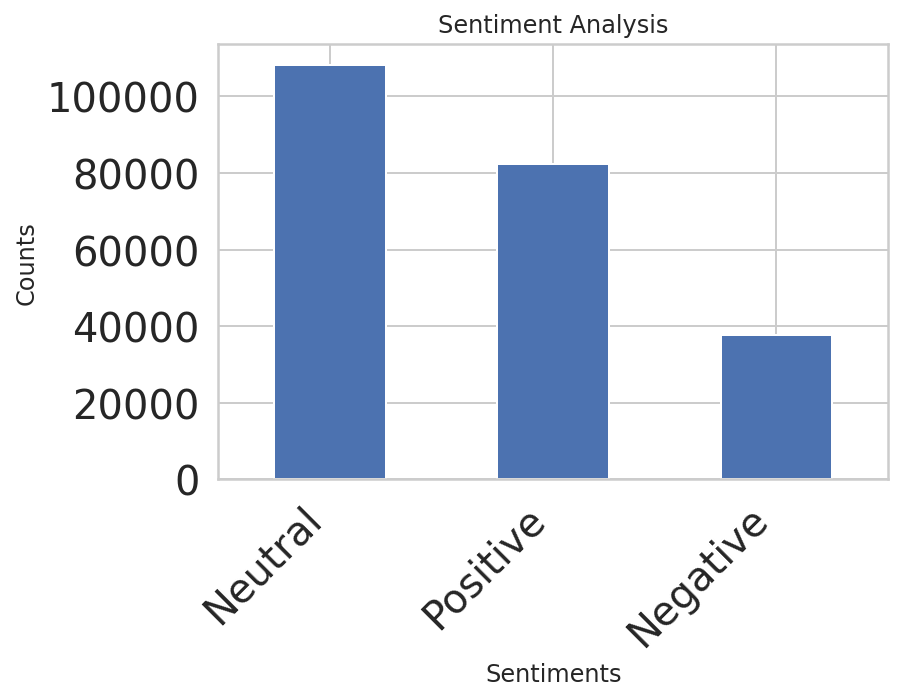

In [58]:
## show value counts
df['vader_analysis'].value_counts()

## plot visulatisation of count
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments') 
plt.ylabel('Counts')
df['vader_analysis'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=20)
plt.yticks(fontsize=20)
plt.show()

<AxesSubplot:xlabel='vader_analysis', ylabel='count'>

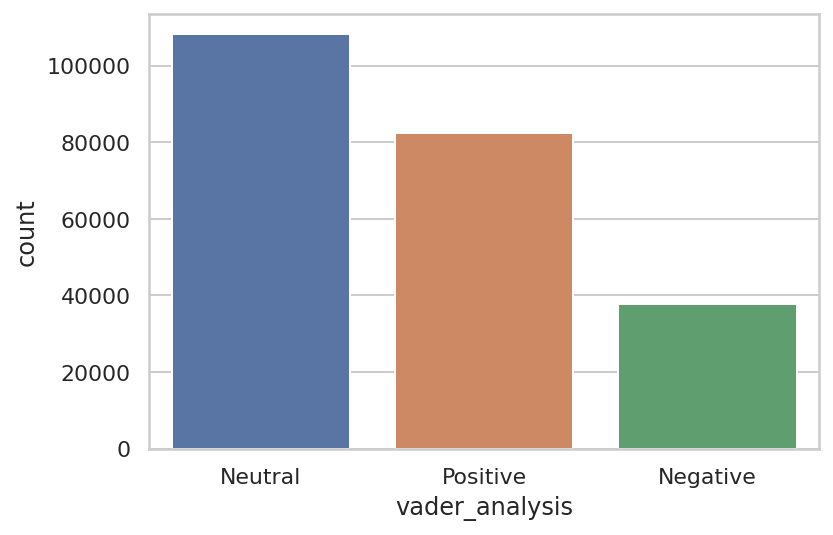

In [59]:
sns.countplot(x=df.vader_analysis, data=df['vader_analysis'], order = df['vader_analysis'].value_counts().index)

# Step 11: ML TF-IDF and Text Classification and K-Means Clustering 

TF-IDF Scheme for Text to Numeric Feature Generation

Several approaches have been developed for converting text to numbers. Bag of Words, N-grams, etc

The text clustering algorithm works in five stages enumerated below:-

**Transformations on raw stream of free flow text

**Creation of Term Document Matrix

**TF-IDF (Term Frequency – Inverse Document Frequency) Normalization

**K-Means Clustering using Euclidean Distances

**Auto-Tagging based on Cluster Centers

Reference: https://python.gotrained.com/tf-idf-twitter-sentiment-analysis/

### Bag of Words - Document-Term Matrix(DTM) Implementation
#### In the bag of words approach, the vocabulary of all the unique words in all the documents is formed. This vocabulary serves as a feature vector.

In [60]:
# Create Document-Term Matrix(DTM) --generate document term matrix by using scikit-learn's CountVectorizer
# max_features: The CountVectorizer will select the words/features/terms which occur the most frequently. 

cv = CountVectorizer(max_features=3000, lowercase=True, min_df=2) # will leave only 2000 words

# Joined the tokenized lists in column
%time count_vector = cv.fit_transform(df['clean_lem'].apply(lambda x: " ".join(x)) ) 
print(count_vector.shape)

CPU times: user 2.43 s, sys: 78 ms, total: 2.51 s
Wall time: 2.5 s
(228207, 3000)


In [61]:
# show resulting vocabulary; the numbers are not counts, they are the position in the sparse vector
#cv.vocabulary_

In [62]:
df_dtm =pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names())
df_dtm.head()

,aarthi,aatmanirbharbharat,ab,able,abroad,absolute,absolutely,abt,abuse,accept,accepted,accepting,accepts,access,according,account,ache,achieve,achieved,achievement,achy,across,act,action,active,activity,actual,actually,ad,add,added,adding,addition,additional,address,addresshe,adenovirus,admin,administer,administered,administering,administration,admits,adolescent,adult,advance,adverse,advice,advise,adviser,advisory,af,affair,affect,afraid,africa,african,afternoon,ag,agadi,age,aged,agency,agenda,ago,agree,agreed,agreement,ahead,ahmedabad,ai,aid,aiims,aim,aint,air,airline,airport,aka,al,alert,algeria,alhamdulillah,alive,allegation,allergic,allergy,alleviate,allow,allowed,allowing,allows,almost,alone,along,alpha,already,also,alternative,although,...,wearing,website,webull,wed,wednesday,week,weekend,weird,welcome,welfare,well,wellness,wellspring,went,wes,west,western,weve,wf,wh,whatever,whats,whatsapp,whether,whit,white,whitefield,who,whole,whose,whove,wi,wife,wil,willing,win,wing,winter,wish,wit,within,without,wo,wockhardt,woke,woman,wonder,wonderful,wondering,wont,woohoo,word,work,worked,worker,working,world,worldwide,worried,worry,worse,worst,worth,would,wouldnt,wow,wrong,wtf,wuhan,ya,yall,yay,ye,yeah,year,yearold,yearolds,yel,yelahanka,yellow,yellowcard,yes,yesterday,yet,ymoderna,yo,york,youll,young,younger,youre,youth,youtube,youve,yr,zeneca,zero,zimbabwe,zombie,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
filter_col = [col for col in df_dtm if col.startswith('covid')]
filter_col

#df_dtm[["covid", "covidemergency"]]

['covid',
 'covidbooster',
 'covidemergency',
 'covidindia',
 'covidiots',
 'covidlk',
 'covidnsw',
 'covidsecondwave',
 'covidshield',
 'covidsl',
 'coviduk',
 'covidupdate',
 'covidvacccine',
 'covidvaccination',
 'covidvaccine',
 'covidvaccines',
 'covidvic']

### TF-IDF (Another technique to create the DTM is the TF-IDF)

#### In a simple bag of words, every word is given equal importance. The idea behind TF-IDF is that the words that occur more frequently in one document and less frequently in other documents should be given more importance as they are more useful for classification. Convert a collection of raw documents to a matrix of TF-IDF features.

#### TF-IDF is a product of two terms: TF and IDF

#### Equivalent to CountVectorizer followed by TfidfTransformer.

In [64]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')


# Define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_features=40000, lowercase = True, use_idf=True) # use_idfbool, default=True: Enable inverse-document-frequency reweighting
tfidf_vectorizer

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_lem'].apply(lambda x: " ".join(x))) 

print(tfidf_matrix.shape)

TfidfVectorizer(max_features=30000)

CPU times: user 2.45 s, sys: 90.1 ms, total: 2.54 s
Wall time: 2.53 s
(228207, 30000)


In [65]:
df_tfidf =pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())
df_tfidf.head()
df_tfidf[["covid", "covidemergency"]]

,aa,aaaaaaand,aaaaaand,aaaaand,aaaand,aaand,aacn,aadhaar,aadhar,aadmi,aadu,aagain,aah,aai,aaiclas,aais,aaj,aajkibaat,aal,aam,aana,aanandayya,aanandayyo,aap,aapda,aapdelhihealthbulletin,aapl,aapsafetohindiasafe,aaptards,aar,aarogy,aarogya,aarogyasethu,aarogyasetu,aaron,aaronmat,aaronrodgers,aarthi,aashish,aastrazeneca,aate,aatma,aatmanirbhar,aatmanirbharbharat,aatmnirbharbharat,aaya,aayega,aayog,aayogs,aayug,ab,ababa,abad,abandon,abandoned,abandoning,abang,abating,abb,abbajaan,abbas,abbigere,abbott,abbottfailedtexas,abby,abc,abcellera,abcl,abcnews,abd,abdala,abdomen,abdominal,abdoolkarim,abducted,abdul,abdullah,abdulrazakgurnah,abe,abhayahas,abhayahasta,abhealth,abhi,abhijitbangar,abhinandan,abhorrent,abi,ability,abinader,abit,abkhazia,abl,able,abled,ableg,ably,abnb,abnormal,abnormality,abo,...,yvonne,yyc,yyj,za,zab,zacks,zaev,zafarul,zahawi,zahid,zaidi,zaini,zak,zakharova,zaks,zambelli,zambia,zamboanga,zanzibar,zara,zardari,zavemtem,zayain,zayed,zazzle,zcovd,ze,zeal,zealand,zebronics,zeck,zee,zeenews,zeitung,zelenkoprotocol,zelensky,zeman,zemocut,zenaca,zendal,zene,zeneca,zenecas,zengeza,zenica,zeolite,zer,zero,zerocovid,zerodha,zeropercent,zetaspavingtheway,zh,zhang,zhengxin,zhenhong,zhou,zhuang,zhyanenglish,zi,ziauddin,zients,zika,zilch,zim,zimb,zimbabwe,zimbabwean,zimcovidvaccination,zimvaccination,zinc,zindabad,zindagi,zip,zixiang,zlem,zm,zo,zoe,zomato,zombie,zone,zoom,zoomed,zoran,zuckerberg,zuellig,zulu,zuma,zune,zw,zweli,zwelimkhize,zx,zycov,zycovd,zydus,zyduscadila,zyduscadilas,zyklonb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

,covid,covidemergency
0,0.000000,0.0
1,0.000000,0.0
2,0.169868,0.0
3,0.000000,0.0
4,0.000000,0.0
...,...,...
228202,0.000000,0.0
228203,0.000000,0.0
228204,0.000000,0.0
228205,0.000000,0.0


In [71]:
word_features = tfidf_vectorizer.get_feature_names()
print(len(word_features))
print(word_features[100:300])

30000
['aboard', 'aboriginal', 'aborted', 'abortion', 'abou', 'abov', 'abovementioned', 'abpoli', 'abq', 'abr', 'abraham', 'abril', 'abro', 'abroa', 'abroad', 'abrupt', 'abruptly', 'abscbn', 'absence', 'absent', 'absolut', 'absolute', 'absolutely', 'absolutelynot', 'absorption', 'abstain', 'abstaining', 'abstract', 'abstractart', 'absurd', 'abt', 'abu', 'abudhabi', 'abudhabis', 'abudiman', 'abudinear', 'abundance', 'abundant', 'abundantly', 'abus', 'abuse', 'abused', 'abusing', 'abusive', 'abut', 'abv', 'abvax', 'abvp', 'abxis', 'aby', 'abysmal', 'abysmally', 'ac', 'acaba', 'academia', 'academic', 'academician', 'academictwitter', 'academy', 'acalan', 'acc', 'acce', 'accelerat', 'accelerate', 'accelerated', 'accelerates', 'accelerating', 'acceleration', 'accent', 'accenture', 'accentureph', 'accep', 'accept', 'acceptab', 'acceptability', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessed', 'accessibility', 'accessible', 'accessing', 'accessory', 'acche'

Features that has highest TF-IDF value

In [74]:
global_top10_idx = tfidf_matrix.toarray().max(axis=0).argsort()[-10:]
global_top10_idx

np.asarray(tfidf_vectorizer.get_feature_names())[global_top10_idx]

array([ 6617, 20643, 26908,  1720,  2729, 20773,  9414, 28611, 15450,
        4259])

array(['damn', 'press', 'tra', 'asmadurlar', 'bergman', 'problem',
       'fanatic', 'vikas', 'lookin', 'cc'], dtype='<U34')

### Cosine similarity

#### Smaller the angle, higher the similarity.

#### Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus

#### Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane

####  dist it is possible to evaluate the similarity of any two or more synopses.

In [68]:
#dist = 1 - cosine_similarity(tfidf_matrix)

### K Means Clustering with TF-IDF weights

#### Elbow method to select number of clusters

This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. 

Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.


#### WCSS and Find Optimal Number of Clusters

Each cluster is formed by calculating and comparing the distances of data points within a cluster to its centroid. An ideal way to figure out the right number of clusters would be to calculate the Within-Cluster-Sum-of-Squares (WCSS).

#### SStotal=SSwithin+SSbetween. So, if SSwithin is minimized then SSbetween is maximized.

Initialization complete
Iteration 0, inertia 453767.3560188173
Iteration 1, inertia 224316.13726992364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 455738.4442401053
Iteration 1, inertia 224316.13726992364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 450075.2323561871
Iteration 1, inertia 224316.13726992364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 450354.92903304443
Iteration 1, inertia 224316.13726992364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 446506.049417307
Iteration 1, inertia 224316.13726992364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 449829.7448002371
Iteration 1, inertia 224316.13726992364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 440115.3668617393
Iteration 1, inertia 224316.13726992364
Con

KMeans(n_clusters=1, random_state=0, verbose=True)

Initialization complete
Iteration 0, inertia 446935.15941681294
Iteration 1, inertia 222648.67951634273
Iteration 2, inertia 222263.15110873562
Iteration 3, inertia 221418.81556436984
Iteration 4, inertia 219914.60843141007
Iteration 5, inertia 218327.65078955266
Iteration 6, inertia 218043.6047725438
Iteration 7, inertia 218040.35344230625
Iteration 8, inertia 218039.9975036292
Converged at iteration 8: center shift 2.234895318073316e-09 within tolerance 3.2765009730913427e-09.
Initialization complete
Iteration 0, inertia 446606.69237711024
Iteration 1, inertia 222827.3724540179
Iteration 2, inertia 220801.68925128694
Iteration 3, inertia 219163.6713611367
Iteration 4, inertia 218081.85924985135
Iteration 5, inertia 218040.44091695716
Iteration 6, inertia 218040.00746806603
Iteration 7, inertia 218039.99742616774
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 431332.5392686513
Iteration 1, inertia 220414.3117034209
Iteration 2, inertia 21873

KMeans(n_clusters=2, random_state=0, verbose=True)

Initialization complete
Iteration 0, inertia 443208.716672225
Iteration 1, inertia 219638.82745734957
Iteration 2, inertia 217192.18396674248
Iteration 3, inertia 216789.7723649051
Iteration 4, inertia 216784.27899222757
Iteration 5, inertia 216782.7412362867
Iteration 6, inertia 216782.25961911402
Iteration 7, inertia 216782.1202276702
Iteration 8, inertia 216782.06328751167
Iteration 9, inertia 216782.04495494725
Iteration 10, inertia 216782.0390280734
Iteration 11, inertia 216782.03329216203
Iteration 12, inertia 216782.03191615926
Iteration 13, inertia 216782.03159339257
Converged at iteration 13: center shift 1.7924121057216446e-09 within tolerance 3.2765009730913427e-09.
Initialization complete
Iteration 0, inertia 439117.58603508316
Iteration 1, inertia 222288.74829844222
Iteration 2, inertia 219240.55690691178
Iteration 3, inertia 218226.12135529998
Iteration 4, inertia 217609.76656591415
Iteration 5, inertia 217575.5088448062
Iteration 6, inertia 217555.43059675535
Iteration 7

Iteration 6, inertia 217105.40946083175
Iteration 7, inertia 217103.44920535202
Iteration 8, inertia 217101.7561637569
Iteration 9, inertia 217100.1125902983
Iteration 10, inertia 217098.44893309654
Iteration 11, inertia 217096.40584224032
Iteration 12, inertia 217093.75112185397
Iteration 13, inertia 217090.63266288023
Iteration 14, inertia 217084.89896796204
Iteration 15, inertia 217074.65237235127
Iteration 16, inertia 217055.77546968835
Iteration 17, inertia 217024.43757472854
Iteration 18, inertia 216981.0642220989
Iteration 19, inertia 216938.79182029364
Iteration 20, inertia 216897.088041538
Iteration 21, inertia 216858.86390960545
Iteration 22, inertia 216824.87158997892
Iteration 23, inertia 216797.03169307136
Iteration 24, inertia 216786.03366789527
Iteration 25, inertia 216783.1102703996
Iteration 26, inertia 216782.38236767103
Iteration 27, inertia 216782.1764990598
Iteration 28, inertia 216782.10694241544
Iteration 29, inertia 216782.06077008994
Iteration 30, inertia 21678

KMeans(n_clusters=3, random_state=0, verbose=True)

Text(0.5, 1.0, 'The Elbow Method')

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'WCSS')

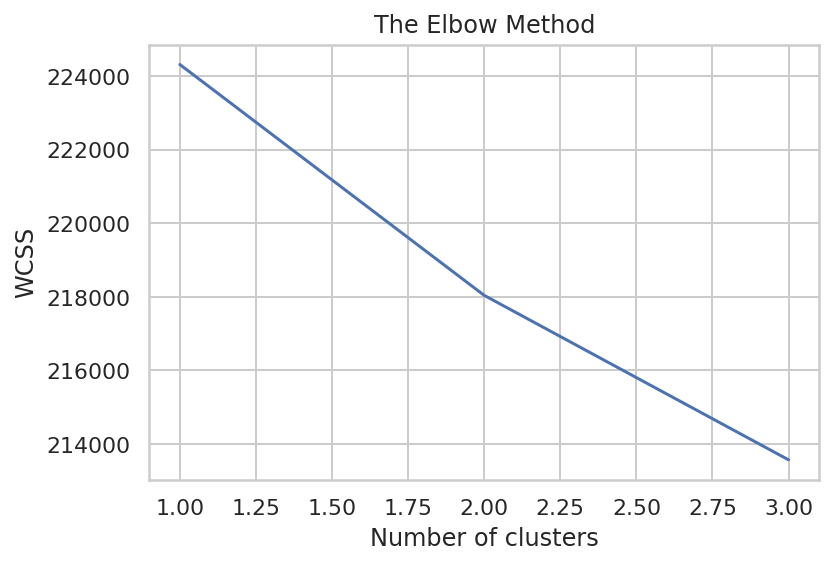

In [83]:
wcss = [] #WCSS is the sum of squared distance between each point and the centroid in a cluster.
for i in range(1,4):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0, verbose=True)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

# Visualization 
plt.plot(range(1,4),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

### 3 Clusters

In [106]:
kmeans = KMeans(n_clusters = 3, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(tfidf_matrix)

# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

/usr/local/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


KMeans(n_clusters=3, n_init=20, n_jobs=1)

0 : pfizervaccine, pfizercovidvaccine, his, nurse, vaccine, coronavirus, covid, history, christmas, there, shop, covid, covid, and, pfizercovidvaccine, pfizerbiontech, begin, pfizerbiontech, december, for, pandemicbegone, does, video, of, case
1 : pakistan, but, his, have, person, beginning, covid, vaccine, of, singh, getting, says, begun, once, to, the, reali, coronavirus, englands, message, this, a, resource, th, usually
2 : but, the, making, about, vaccine, efficacy, pandemicbegone, pfizerbiontech, advances, but, have, pain, covid, his, usa, pfizercovidvaccine, pfizervaccine, my, i, regional, health, pfizerbiontech, covidvaccine, pfizerbiontech, grateful


### 2 Clusters

In [107]:
kmeans = KMeans(n_clusters = 2, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(tfidf_matrix)

# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

/usr/local/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


KMeans(n_clusters=2, n_init=20, n_jobs=1)

0 : pfizervaccine, pfizercovidvaccine, his, nurse, vaccine, coronavirus, covid, history, christmas, there, shop, covid, covid, and, pfizercovidvaccine, pfizerbiontech, begin, pfizerbiontech, december, for, pandemicbegone, does, video, of, case
1 : but, pakistan, vaccine, have, his, person, beginning, covid, about, the, making, efficacy, pandemicbegone, of, singh, pfizerbiontech, advances, getting, says, but, begun, once, to, the, reali


### Applying of KMeans

In [105]:
true_k = 2

kmeans = KMeans(n_clusters=true_k,init='k-means++',n_init=1)
%time kmeans.fit(tfidf_matrix)

print ("Top terms per Cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:"  % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print
print("\n")

CPU times: user 37.9 s, sys: 1.49 s, total: 39.4 s
Wall time: 1.03 s


KMeans(n_clusters=2, n_init=1)

Top terms per Cluster:
Cluster 0:


(None,)

 vaccine


(None,)

 moderna


(None,)

 covaxin


(None,)

 covid


(None,)

 dose


(None,)

 vaccinated


(None,)

 sputnikv


(None,)

 got


(None,)

 first


(None,)

 pfizer


(None,)

<function print>

Cluster 1:


(None,)

 slot


(None,)

 age


(None,)

 dose


(None,)

 bbmp


(None,)

 covaxin


(None,)

 pincode


(None,)

 fee


(None,)

 date


(None,)

 free


(None,)

 bengaluru


(None,)

<function print>

### Predict using Built KMeans Cluster

In [91]:
Y = tfidf_vectorizer.transform(["i hate vaccine"])
prediction = model.predict(Y)
prediction

array([1], dtype=int32)

### Apply KMeans Clusters back to Dataframe

In [125]:
df['Cluster_Group'] = pd.Series(kmeans.predict(tfidf_matrix), index=df.index) # this is for predicting new data
df.head(20)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,tokenized_text,tweettokenized_text,POS,Tweet_POS,clean_text,clean_tweettokenized_text,clean_Tweet_POS,clean_tweettokenized_text_rmstopwds,clean_ps_stemmed,clean_snow_stemmed,clean_lem,sentiment,polarity,subjectivity,analysis,vader_compound,vader_neg,vader_neu,vader_pos,vader_analysis,Cluster_Group
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405.0,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False,"[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, #, pfizerbiontech, https, :, //t.co/xehhimg1kf]","[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, #pfizerbiontech, https://t.co/xehhimg1kf]","[(same, JJ), (folks, NNS), (said, VBD), (daikon, JJ), (paste, NN), (could, MD), (treat, VB), (a, DT), (cytokine, NN), (storm, NN), (#, #), (pfizerbiontech, JJ), (https, NN), (:, :), (//t.co/xehhimg1kf, NN)]","[(same, JJ), (folks, NNS), (said, VBD), (daikon, JJ), (paste, NN), (could, MD), (treat, VB), (a, DT), (cytokine, NN), (storm, NN), (#pfizerbiontech, NN), (https://t.co/xehhimg1kf, NN)]",same folks said daikon paste could treat a cytokine storm pfizerbiontech,"[same, folks, said, daikon, paste, could, treat, a, cytokine, storm, pfizerbiontech]","[(same, JJ), (folks, NNS), (said, VBD), (daikon, JJ), (paste, NN), (could, MD), (treat, VB), (a, DT), (cytokine, NN), (storm, NN), (pfizerbiontech, NN)]","[folks, said, daikon, paste, could, treat, cytokine, storm, pfizerbiontech]","[folk, said, daikon, past, could, treat, cytokin, storm, pfizerbiontech]","[folk, said, daikon, past, could, treat, cytokin, storm, pfizerbiontech]","[folk, said, daikon, paste, could, treat, cytokine, storm, pfizerbiontech]","(0.0, 0.125)",0.000000,0.125000,Neutral,0.4019,0.000,0.787,0.213,Positive,0
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834.0,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False,"[while, the, world, has, been, on, the, wrong, side, of, history, this, year, ,, hopefully, ,, the, biggest, vaccination, effort, we, 've, ev…, https, :, //t.co/dlchrzjkhm]","[while, the, world, has, been, on, the, wrong, side, of, history, this, year, ,, hopefully, ,, the, biggest, vaccination, effort, we've, ev, …, https://t.co/dlchrzjkhm]","[(while, IN), (the, DT), (world, NN), (has, VBZ), (been, VBN), (on, IN), (the, DT), (wrong, JJ), (side, NN), (of, IN), (history, NN), (this, DT), (year, NN), (,, ,), (hopefully, RB), (,, ,), (the, DT), (biggest, JJS), (vaccination, NN), (effort, NN), (we, PRP), ('ve, VBP), (ev…, VBN), (https, NN), (:, :), (//t.co/dlchrzjkhm, NN)]","[(while, IN), (the, DT), (world, NN), (has, VBZ), (been, VBN), (on, IN), (the, DT), (wrong, JJ), (side, NN), (of, IN), (history, NN), (this, DT), (year, NN), (,, ,), (hopefully, RB), (,, ,), (the, DT), (biggest, JJS), (vaccination, NN), (effort, NN), (we've, NN), (ev, VBP), (…, CD), (https://t.co/dlchrzjkhm, NN)]",while the world has been on the wrong side of history this year hopefully the biggest vaccination effort weve ev,"[while, the, world, has, been, on, the, wrong, side, of, history, this, year, hopefully, the, biggest, vaccination, effort, weve, ev]","[(while, IN), (the, DT), (world, NN), (has, VBZ), (been, VBN), (on, IN), (the, DT), (wrong, JJ), (side, NN), (of, IN), (history, NN), (this, DT), (

In [128]:
df1 = df[df["Cluster_Group"].isin(['1'])]
df1.head(20)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,tokenized_text,tweettokenized_text,POS,Tweet_POS,clean_text,clean_tweettokenized_text,clean_Tweet_POS,clean_tweettokenized_text_rmstopwds,clean_ps_stemmed,clean_snow_stemmed,clean_lem,sentiment,polarity,subjectivity,analysis,vader_compound,vader_neg,vader_neu,vader_pos,vader_analysis,Cluster_Group
46230,1378967820990521352,Sai Nikesh Theertala,"Badvel, Andhra Pradesh",cricket ❤️ 👻 : snikesh19,2015-11-12 10:11:50,39.0,301,7855,False,2021-04-05 07:08:43,#Covaxin dose1 ✅,['Covaxin'],Twitter for iPhone,0,0,False,"[#, covaxin, dose1, ✅]","[#covaxin, dose, 1, ✅]","[(#, #), (covaxin, NN), (dose1, NN), (✅, NN)]","[(#covaxin, NN), (dose, VBD), (1, CD), (✅, NN)]",covaxin dose,"[covaxin, dose]","[(covaxin, NN), (dose, NN)]","[covaxin, dose]","[covaxin, dose]","[covaxin, dose]","[covaxin, dose]","(0.0, 0.0)",0.00,0.00,Neutral,0.0,0.0,1.0,0.0,Neutral,1
73390,1395543730208137217,Bangalore 45+(Covaxin) & 18+ Vaccine,NaN,Follow us to get update as soon as 18 plus vaccine appointments open up in Bangalore & Covaxin for 45+ #TwitterBot created by \n@17abhi89,2021-05-17 18:56:45,160.0,0,2,False,2021-05-21 00:55:27,"#COVAXIN @ MANIPAL NORTHSIDE CANARA UNIO - 560003 for AGE 45+(Capacity: 50, Dose 1 - 25 Dose 2: 25 slots) on 21-05-2021",['COVAXIN'],cowin_vaccine_app,0,0,False,"[#, covaxin, @, manipal, northside, canara, unio, -, 560003, for, age, 45+, (, capacity, :, 50, ,, dose, 1, -, 25, dose, 2, :, 25, slots, ), on, 21-05-2021]","[#covaxin, @, manipal, northside, canara, unio, -, 560003, for, age, 45, +, (, capacity, :, 50, ,, dose, 1, -, 25, dose, 2, :, 25, slots, ), on, 21-05-, 2021]","[(#, #), (covaxin, NN), (@, NN), (manipal, JJ), (northside, RB), (canara, NN), (unio, JJ), (-, :), (560003, CD), (for, IN), (age, NN), (45+, CD), ((, (), (capacity, NN), (:, :), (50, CD), (,, ,), (dose, RB), (1, CD), (-, :), (25, CD), (dose, JJ), (2, CD), (:, :), (25, CD), (slots, NNS), (), )), (on, IN), (21-05-2021, JJ)]","[(#covaxin, NN), (@, NN), (manipal, JJ), (northside, RB), (canara, NN), (unio, JJ), (-, :), (560003, CD), (for, IN), (age, NN), (45, CD), (+, NN), ((, (), (capacity, NN), (:, :), (50, CD), (,, ,), (dose, RB), (1, CD), (-, :), (25, CD), (dose, JJ), (2, CD), (:, :), (25, CD), (slots, NNS), (), )), (on, IN), (21-05-, JJ), (2021, CD)]",covaxin manipal northside canara unio for age capacity dose dose slots on,"[covaxin, manipal, northside, canara, unio, for, age, capacity, dose, dose, slots, on]","[(covaxin, NN), (manipal, JJ), (northside, RB), (canara, VBP), (unio, JJ), (for, IN), (age, NN), (capacity, NN), (dose, VBP), (dose, JJ), (slots, NNS), (on, IN)]","[covaxin, manipal, northside, canara, unio, age, capacity, dose, dose, slots]","[covaxin, manip, northsid, canara, unio, age, capac, dose, dose, slot]","[covaxin, manip, northsid, canara, unio, age, capac, dose, dose, slot]","[covaxin, manipal, northside, canara, unio, age, capacity, dose, dose, slot]","(0.0, 0.0)",0.00,0.00,Neutral,0.0,0.0,1.0,0.0,Neutral,1
73581,1395379953814753283,tweetcovidvaccine,"Bengaluru, India",An initiative to send alerts to all the followers as soon as the doses available at the centers from #BBMP district. #vaccinateme_blr,2021-05-12 09:50:14,58.0,18,1,False,2021-05-20 14:04:40,#VACCINE_ALERT #DOSE1 for age 18 and Above in MANIPAL WHITEFIELD COVAXIN 560066 #BBMP has 26 Paid #COVAXIN on 21-05… https://t.co/W4KFBLtQ08,"['VACCINE_ALERT', 'DOSE1', 'BBMP', 'COVAXIN']",tweetvaccine,0,0,False,"[#, vaccine_alert, #, dose1, for, age, 18, and, above, in, manipal, whitefield, covaxin, 560066, #, bbmp, has, 26, paid, #, covaxin, on, 21-05…, https, :, //t.co/w4kfbltq08]","[#vaccine_alert, #dose1, for, age, 18, and, above, in, manipal, whitefield, covaxin, 560066, #bbmp, has, 26, paid, #covaxin, on, 21-05, …, https://t.co/w4kfbltq08]","[(#, #), (vaccine_alert, JJ), (#, #), (dose1, NN), (for, IN), (age, NN), (1